# Reproduce the Results for the Public Datasets

Here, we report the code to reproduce the results reported in our work "GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning".

Especially, the code below allows to train four different machine learning classifiers (random forest, gradient boosting, XGBoost, and logistic regression) in combination with two different molecular descriptors (ECFP4 and RDKit2D). The models are trained on 138 public datasets, which are described and used in [this RDKit blog post](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) by Greg Landrum.

For a step by step execution and explanation of the code, see the tutorial `Tutorial_Threshold_Optimization_RF.ipynb`.

### Outlook

[Import Libraries](#section0) <br>

1. [Functions](#section1)

    1.1 [Functions to prepare the datasets and generate the fingerprints](#section1.1) <br>
    1.2 [Functions to calculate output metrics](#section1.2) <br>
    1.3 [Functions to optimize the decision threhold](#section1.3) <br>
    1.3.1 [Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set](#section1.3.1) <br>
    1.3.2 [Generalized procedure to optimize the decision threshold](#section1.3.2) <br>
    1.4 [Functions to run other rebalancing approaches: RUS, SMOTE, and balanced random forest](#section1.4) <br>
    1.5 [Functions for Conformal Prediction](#section1.5) <br>
    1.6 [Function to run everything and store the results into an archive](#section1.6) <br>
    
    
2. [Run the code](#section2)

    2.1 [Set Parameters](#section2.1) <br>
    2.2 [Serotonin Datasets](#section2.2) <br>
    2.3 ["Dataset 1" (DS1) Datasets](#section2.3) <br>
    2.4 [PubChem Datasets](#section1.3.1) <br>
    2.5 [CHEMBL DrugMatrix Datasets](#section2.4) <br>
    
   
3. [Plot Results](#section3)<br>

<a id='section0'></a>

### Import Libraries

In [14]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit import SimDivFilters
from rdkit.Chem.MolStandardize import rdMolStandardize

from collections import defaultdict
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator

In [6]:
from sklearn.model_selection import train_test_split
import sklearn
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
except ImportError:
    xgb = None
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [7]:
# only print out critical error messages of rdkit and reduce verbosity of xgboost
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

<a id='section1'></a>

# 1. Functions

<a id='section1.1'></a>

### 1.1 Functions to prepare the datasets and generate the fingerprints

In [78]:
# Remove counterions: Take the largest organic fragment
def salt_remover(smiles):
    rmv = rdMolStandardize.LargestFragmentChooser(preferOrganic = True)
    cleaned_smiles = []
    for smi in smiles:
        if "." in smi:
            smi_new = Chem.MolToSmiles(rmv.choose(Chem.MolFromSmiles(smi)))
            cleaned_smiles.append(smi_new)
        else:
            cleaned_smiles.append(smi)
    return cleaned_smiles



# Compute the ECFP4 fingerprint with 2048 bits
def add_MorganFP(acts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append(bv)
    acts['MorganFP'] = act_data
    return(acts)


# Compute the RDKit2D fingerprint (200 topological properties) using the descriptastorus library
def add_rdkit2d(acts, smiles_column = 'canonical_smiles'):
    if smiles_column not in list(acts):
        print("Error: the column {} is not contained in the input dataframe. A column containing SMILES is required to calculate property-based fingerprints".format(smiles_column))
        return(acts)
    acts[smiles_column] = acts[smiles_column].astype(str)
    rdkit2d = []
    generator = MakeGenerator(("RDKit2D",))
    for n, smi in enumerate(acts[smiles_column]):
        try:
            data = generator.process(smi)
            if data[0] == True:
                data.pop(0)
            if data[0] == False:
                data.pop(0)
            data = np.float32(data)
            data[np.isposinf(data)] = np.finfo('float32').max
            data[np.isneginf(data)] = np.finfo('float32').min
            data = np.nan_to_num(data)
            rdkit2d.append(list(data))
        except:
            rdkit2d.append([0]*200)
            print("Error: RDKit2D not generated for {}".format(acts['compound_chembl_id'][n]))
    acts['RDKit2D'] = rdkit2d
    return(acts)


def gen_fps(acts,inacts, descriptor = 'MorganFP'):
    # generate fingerprints for the actives and inactives and convert them to numpy arrays so that
    # we can learn from them. This uses the generalized fingerprinter added in the RDKit 2018.09 release
    labels_column = 'labels'
    if descriptor == 'RDKit2D':
        acts = add_rdkit2d(acts)
        inacts = add_rdkit2d(inacts)
    if descriptor == 'MorganFP':
        acts = add_MorganFP(acts)
        inacts = add_MorganFP(inacts)
    acts[labels_column] = 1
    inacts[labels_column] = 0
    df_dataset = pd.concat((acts, inacts))
    df_dataset.reset_index(inplace = True, drop = True)
    # exclude the compounds for which RDKit2D could not be completely calculated
    if descriptor == 'RDKit2D':
        check_idx = [i for i,a in enumerate(list(df_dataset[descriptor])) if len(a) != 200]
        df_dataset.drop(check_idx, inplace=True) 
    return df_dataset



<a id='section1.2'></a>

### 1.2 Function to calculate output metrics

In [9]:
def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return kappa, confusion, auc



<a id='section1.3'></a>

### 1.3 Functions to optimize the decision threhold

<a id='section1.3.1'></a>
#### 1.3.1 Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set 
This approach has been described [here](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) and can only be used for the random forest classifier.

The function below requires as input:
- `oob_probs`: the oob active prediction probabilities, which can be extracted from the trained RF model (cls) as 

        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        
- `labels_train`: the true labels of the training set 
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])

To optmize the decision threshold, one can use different metrics. 
Here, you can select `ThOpt_metrics = 'Kappa'`, `'ROC'`, or `'ROC_Song14'`.

With, `ThOpt_metrics = 'Kappa'`, the Cohen's Kappa is calculated for the oob set and a range of thresholds (specified using the threshold argument). The optimal threshold (returned) is the one that maximizes the Cohen's Kappa.

The threshold optimization based on the ROC curve is described [here](https://doi.org/10.1007/s11548-013-0913-8). With, `ThOpt_metrics = 'ROC'`, sensitivity and specificity are calculated for a range of thresholds using the roc_curve function of scikit-learn. The optimal threshold (returned) is the one that minimizes the distance to the [0,1] corner of the ROC plot. 

In [10]:
def run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):
    """Optimize the decision threshold based on the prediction probabilities of the out-of-bag set of random forest.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the out-of-bag set is chosen as optimal.
    
    Parameters
    ----------
    oob_probs : list of floats
        Positive prediction probabilities for the out-of-bag set of a trained random forest model
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
        
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """

    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        tscores = []
        # evaluate the score on the oob using different thresholds
        for thresh in thresholds:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(labels_train,scores)
            tscores.append((np.round(kappa,3),thresh))
        # select the threshold providing the highest kappa score as optimal
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
    # Optmize the decision threshold based on the ROC-curve
    elif ThOpt_metrics == 'ROC':
        # ROC optimization with thresholds determined by the roc_curve function of sklearn
        fpr, tpr, thresholds_roc = metrics.roc_curve(labels_train, oob_probs, pos_label=1)
        specificity = 1-fpr
        roc_dist_01corner = (2*tpr*specificity)/(tpr+specificity)
        thresh = thresholds_roc[np.argmax(roc_dist_01corner)]
    return thresh



<a id='section1.3.2'></a>

#### 1.3.2 GHOST: Generalized procedure to optimize the decision threshold
The function below utilizes the prediction probabilities of N training subsets (`N_subsets`) to optimize the classification threshold. The subsets can be drawn with or without replacement (`with_replacement`). The subset size can be selected using the `subset_size` argument (default = 0.2), which, if float, represents the proportion of the dataset to include in the subset. If integer, it represents the actual number of instances to include in the subset. As for the previous function, two optimization metrics are available `ThOpt_metrics = 'Kappa'` or `ThOpt_metrics = 'ROC'`.

Required inputs are:
- `cls`: trained classification model
- `fps_train`: numpy array of descriptors of the training set
- `labels_train`: list of true labels for the training set
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])


In [79]:
import ghostml
def optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds, 
                                    ThOpt_metrics = 'Kappa', N_subsets = 100, 
                                    subsets_size = 0.2, with_replacement = False, random_seed = None):

    """Optimize the decision threshold based on subsets of the training set.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the training subsets is chosen as optimal.
    
    Parameters
    ----------
    cls : obj
        Trained machine learning classifier built using scikit-learn
    fps_train: list 
        Molecular descriptors for the training set
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
    N_subsets: int
        Number of training subsets to use in the optimization
    subsets_size: float or int
        Size of the subsets. if float, represents the proportion of the dataset to include in the subsets. 
        If integer, it represents the actual number of instances to include in the subsets. 
    with_replacement: bool
        The subsets are drawn randomly. True to draw the subsets with replacement
    random_seed: int    
        random number to seed the drawing of the subsets
    
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """   
    # calculate prediction probability for the training set
    probs_train = cls.predict_proba(fps_train)[:,1]
    opt_thresh = ghostml.optimize_threshold_from_predictions(labels_train,probs_train,thresholds,
                                                    ThOpt_metrics=ThOpt_metrics,N_subsets=N_subsets,
                                                    subsets_size=subsets_size,with_replacement=with_replacement,
                                                    random_seed = random_seed)

    return opt_thresh

<a id='section1.6'></a>

### 1.6 Function to run everything and store the results into an archive

In [89]:
def run_it_(assay_id, acts, inacts, archive, descriptor = 'MorganFP', method = "RF", scale_features = False, 
            test_set_size = 0.2, random_seed = None, 
            opt_oob = False, ThOpt_metrics = 'Kappa', thresholds = None, N_subsets = None, 
            subsets_size = None, with_replacement = False, **kwargs):
    
    # clean data:
    acts.canonical_smiles = salt_remover(acts['canonical_smiles'])
    inacts.canonical_smiles = salt_remover(inacts['canonical_smiles'])
    
    # generate descriptors and split the data into a training and test set:
    df_dataset = gen_fps(acts,inacts, descriptor = descriptor)

    # return fps and true labels
    labels = np.array(list(df_dataset['labels']))
    fps = np.array(df_dataset[descriptor])
    fps = np.stack(fps, axis = 0)
     # retrieve compound IDs
    mol_names = list(df_dataset['compound_chembl_id']) 
    
    # scale features:
    if scale_features:
        scaler = StandardScaler()
        fps = scaler.fit_transform(fps)

    # train - test split
    fps_train, fps_test, labels_train, labels_test, names_train, names_test = train_test_split(fps, labels, mol_names, 
                                                                      test_size = test_set_size, 
                                                                      stratify = labels, random_state = random_seed)
    # train classifier
    print("--------- Default -----------")
    if method  == 'RF':
        cls = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2,oob_score = True,
                                     n_jobs=4, random_state=random_seed, **kwargs)
    elif method == 'GB':
        cls = GradientBoostingClassifier(n_estimators = 100, validation_fraction = 0.2, n_iter_no_change = 10, 
                                         tol = 0.01, random_state=random_seed, **kwargs)
    elif method == 'XGB':
        cls = xgb.XGBClassifier(n_estimators = 100, **kwargs)
        
    elif method == 'LR':
        cls = LogisticRegression(random_state=random_seed, **kwargs)
    
    if method == 'XGB':
        cls.fit(fps_train, labels_train, early_stopping_rounds=10, eval_metric="error", 
                eval_set=[(fps_train, labels_train)])
    else:
        cls.fit(fps_train, labels_train)

    # predict the test set
    test_probs = cls.predict_proba(fps_test)[:,1] #prediction probabilities for the test set
    #store predictions in dataframe
    scores = [1 if x>=0.5 else 0 for x in test_probs]
    df_preds = pd.DataFrame({'mol_names': names_test, 'y_true': labels_test, 'standard': scores})
   
    # generate and show some evaluation stats for the model on the test data:
    kappa, confusion, auc = calc_metrics(labels_test, test_probs, threshold = 0.5)
    archive[assay_id].append(('standard',0.5,kappa,confusion,auc))
    
    # Optimize decision threshold
    print("--------- Balanced -----------")
    if thresholds is None:
        # pick the best threshold using the OOB kappas
        thresholds = np.round(np.arange(0.05,0.55,0.05),2)
        
    # optimize the decision thresholds based on the prediction probabilities of the oob set
    # Can only be used for random forest
    if opt_oob == True and method == 'RF':
        print("--------- Balanced Oob -----------")
        # extract oob probabilities
        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        oob_auc = metrics.roc_auc_score(labels_train, oob_probs)
        # optimize threshold
        thresh_oob = run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = ThOpt_metrics)  
        # calculate metrics using the optimized decision threshold
        kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_oob)
        archive[assay_id].append(('OobOpt',thresh_oob,kappa,confusion,oob_auc))
        #store predictions in dataframe
        scores = [1 if x>=thresh_oob else 0 for x in test_probs]
        df_preds['OobOpt'] = scores
        
    print("--------- Balanced Subsets -----------")
    # optimize the decision thresholds based on the prediction probabilities of N training subsets
    # Can be used for every machine learning model
    thresh_sub = optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds,
                                                              ThOpt_metrics = ThOpt_metrics, 
                                                              N_subsets = N_subsets, subsets_size = subsets_size, 
                                                              with_replacement = with_replacement, random_seed = random_seed) 
    #store predictions in dataframe
    scores = [1 if x>=thresh_sub else 0 for x in test_probs]
    df_preds['GHOST'] = scores    
    # calculate metrics using the optimized decision threshold
    kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_sub)
    archive[assay_id].append(('GHOST',thresh_sub,kappa,confusion,auc_tmp))

    return df_preds




<a id='section2'></a>


# 2. Run the code

<a id='section2.1'></a>

### 2.1 Set Paramenters

In [81]:
# parameters to build model
method = 'GB' # choose between RF, GB, XGB, and LR
descriptor = 'MorganFP' # choose between MorganFP and RDKit2D
scale_features = False
test_set_size = 0.2

# parameters for threshold optimization - we use default values for most parameters
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
random_seed = 16
#these are default:
ThOpt_metrics = 'Kappa'
N_subsets = 100
subsets_size = 0.2
with_replacement = False
opt_oob = True # only for RF, one can also optimize the threshold using the oob-based method

In [82]:
# create folders where to store the output files 
import os

if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists("figures"):
    os.makedirs("figures")

The results shown in the paper were averaged over 50 train-test splits. The 50 random seeds used for the paper are:

In [83]:
list_random_seeds_paper = [16, 102, 279, 314, 325, 376, 382, 398, 453, 490 , 
                           10, 133, 181, 202, 269, 304, 317, 392, 429, 447,
                           109, 124, 137, 145, 155, 170, 297, 435, 470, 481,
                           33, 37, 59, 76, 299, 340, 412, 444, 471, 493,
                           48, 82, 132, 175, 191, 253, 264, 364, 399, 478]

<a id='section2.2'></a>

### 2.2 Serotonin Datasets
This is a set of data about binding to serotonin receptors exported from ChEMBL.

In [84]:
with open('data/serotonin_data.pkl','rb') as inf:
    serotonin_d,assay_lookup = pickle.load(inf)

In [85]:
tpls = sorted([(len(v),k) for k,v in serotonin_d.groupby('target_chembl_id').groups.items()],reverse=True)

**Run the `run_it_` function for all serotonin datasets**

In [86]:
def run_serotonin_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, 
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    # these need to be converted into a classification problem.
    # start with a pretty strict cutoff for active/inactive:
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)>=50:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    else:
        # but relax that if we don't end up with a reasonable number of actives:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    df_preds = run_it_(archive_key, acts[:], inacts[:]
                       , archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


Run it all:

In [133]:
import imp
from ghostml import ghost
imp.reload(ghost)
imp.reload(ghostml)

<module 'ghostml' from '/home/glandrum/ETH/Code/GHOST/ghostml/__init__.py'>

In [144]:
# parameters for threshold optimization - we use default values for most parameters
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
random_seed = 27
#these are default:
ThOpt_metrics = 'Kappa'
N_subsets = 100
subsets_size = 0.2
with_replacement = True
opt_oob = True # only for RF, one can also optimize the threshold using the oob-based method


serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k, serotonin_d, assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=serotonin_archive, archive_key = k,
                           random_seed=random_seed)
        break


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
thresh: 0.50, kappa: 0.617, AUC test-set: 0.911
[[424   4]
 [ 39  42]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       428
           1       0.91      0.52      0.66        81

    accuracy                           0.92       509
   macro avg       0.91      0.75      0.81       509
weighted avg       0.92      0.92      0.91       509

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.30, kappa: 0.725, AUC test-set: 0.911
[[417  11]
 [ 24  57]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       428
           1       0.84      0.70      0.77        81

    accuracy                           0.93       509
   macro avg       0.89      0.84      0.86       509
weighted avg       0.93

In [128]:
serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k, serotonin_d, assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=serotonin_archive, archive_key = k,
                           random_seed=random_seed)
        break


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
thresh: 0.50, kappa: 0.731, AUC test-set: 0.943
[[428   0]
 [ 31  50]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       428
           1       1.00      0.62      0.76        81

    accuracy                           0.94       509
   macro avg       0.97      0.81      0.86       509
weighted avg       0.94      0.94      0.93       509

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.784, AUC test-set: 0.943
[[415  13]
 [ 16  65]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       428
           1       0.83      0.80      0.82        81

    accuracy                           0.94       509
   macro avg       0.90      0.89      0.89       509
weighted avg       0.94

In [105]:
#### Save Results
pickle.dump(serotonin_archive, open(f'./results/serotonin_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.3'></a>

### 2.3 "Dataset 1" (DS1) Datasets

Now we'll work with the "Dataset 1" datasets from the benchmarking set. These are collections of diverse actives from various ChEMBL targets together with assumed inactives pulled from an older version of ZINC.

In [22]:
import glob
datasets = glob.glob('data/ChEMBL/cmp_list*_actives.dat.gz')
print(f"There are {len(datasets)} DS1 datasets")


There are 80 DS1 datasets


In [23]:
import re
with gzip.open('data/ChEMBL/cmp_list_ChEMBL_zinc_decoys.dat.gz') as inf:
    inactive_df = pd.read_csv(inf,sep='\t')

chembl_active_sets = {}
for fn in datasets:
    nm = re.search(r'cmp_list_(ChEMBL_[0-9]*)_actives',fn).groups()[0]
    with gzip.open(fn) as inf:
        chembl_active_sets[nm] = pd.read_csv(inf,sep='\t')

In [24]:
def run_dataset1_assay(assay_id, chembl_active_sets, inactive_df, factor=20, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = chembl_active_sets[assay_id]
    acts = assay.rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})
    inacts = inactive_df.sample(n=factor*len(acts),random_state=hash(assay_id)%0xf00d).rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})

    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}')

    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [25]:
ds1_archive = defaultdict(list)

for k in chembl_active_sets:
        run_dataset1_assay(k, chembl_active_sets, inactive_df, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=ds1_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_19905
--------- Default -----------
thresh: 0.50, kappa: 0.587, AUC test-set: 0.956
[[399   1]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       400
           1       0.90      0.45      0.60        20

    accuracy                           0.97       420
   macro avg       0.94      0.72      0.79       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.35, kappa: 0.611, AUC test-set: 0.956
[[398   2]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.83      0.50      0.62        20

    accuracy                           0.97       420
   macro avg       0.90      0.75      0.81       420
weighted avg       0.97      0.97      0.97       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.460, AUC test-set: 0.873
[[386  14]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       400
           1       0.44      0.55      0.49        20

    accuracy                           0.95       420
   macro avg       0.71      0.76      0.73       420
weighted avg       0.95      0.95      0.95       420

--------- RUS -----------
thresh: 0.50, kappa: 0.164, AUC test-set: 0.894
[[298 102]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       400
           1       0.14      0.80      0.23        20

    accuracy                           0.75       420
   macro avg       0.56      0.77      0.54       420
weighted avg       0.95      0.75      0.82       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_126


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.449, AUC test-set: 0.950
[[400   0]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       1.00      0.30      0.46        20

    accuracy                           0.97       420
   macro avg       0.98      0.65      0.72       420
weighted avg       0.97      0.97      0.96       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.543, AUC test-set: 0.950
[[392   8]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.58      0.55      0.56        20

    accuracy                           0.96       420
   macro avg       0.78      0.77      0.77       420
weighted avg       0.96      0.96      0.96       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.678, AUC test-set: 0.978
[[390  10]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.62      0.80      0.70        20

    accuracy                           0.97       420
   macro avg       0.80      0.89      0.84       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.209, AUC test-set: 0.964
[[294 106]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.73      0.85       400
           1       0.16      1.00      0.27        20

    accuracy                           0.75       420
   macro avg       0.58      0.87      0.56       420
weighted avg       0.96      0.75      0.82       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_20174


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.884, AUC test-set: 0.975
[[400   0]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.80      0.89        20

    accuracy                           0.99       420
   macro avg       1.00      0.90      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.05, kappa: 0.915, AUC test-set: 0.975
[[400   0]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.85      0.92        20

    accuracy                           0.99       420
   macro avg       1.00      0.93      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.915, AUC test-set: 0.962
[[400   0]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.85      0.92        20

    accuracy                           0.99       420
   macro avg       1.00      0.93      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.890, AUC test-set: 0.991
[[399   1]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       0.94      0.85      0.89        20

    accuracy                           0.99       420
   macro avg       0.97      0.92      0.94       420
weighted avg       0.99      0.99      0.99       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12840


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.724, AUC test-set: 0.979
[[396   4]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.78      0.70      0.74        20

    accuracy                           0.98       420
   macro avg       0.88      0.84      0.86       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.758, AUC test-set: 0.979
[[396   4]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.79      0.75      0.77        20

    accuracy                           0.98       420
   macro avg       0.89      0.87      0.88       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.580, AUC test-set: 0.951
[[392   8]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.60      0.60      0.60        20

    accuracy                           0.96       420
   macro avg       0.79      0.79      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.448, AUC test-set: 0.971
[[361  39]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       400
           1       0.33      0.95      0.49        20

    accuracy                           0.90       420
   macro avg       0.66      0.93      0.72       420
weighted avg       0.97      0.90      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_25
--------- Default -----------
thresh: 0.50, kappa: 0.812, AUC test-set: 0.984
[[397   3]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.84      0.80      0.82        20

    accuracy                           0.98       420
   macro avg       0.92      0.90      0.91       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Bala

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.749, AUC test-set: 0.992
[[394   6]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.73      0.80      0.76        20

    accuracy                           0.98       420
   macro avg       0.86      0.89      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.321, AUC test-set: 0.986
[[333  67]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       400
           1       0.23      1.00      0.37        20

    accuracy                           0.84       420
   macro avg       0.61      0.92      0.64       420
weighted avg       0.96      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11225
--------- Default -----------
thresh: 0.50, kappa: 0.676, AUC test-set: 0.915
[[399   1]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.92      0.55      0.69        20

    accuracy                           0.98       420
   macro avg       0.95      0.77      0.84       420
weighted avg       0.98      0.98      0.97       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.749, AUC test-set: 0.979
[[394   6]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.73      0.80      0.76        20

    accuracy                           0.98       420
   macro avg       0.86      0.89      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------
thresh: 0.50, kappa: 0.448, AUC test-set: 0.959
[[367  33]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       400
           1       0.34      0.85      0.49        20

    accuracy                           0.91       420
   macro avg       0.67      0.88      0.72       420
weighted avg       0.96      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11631


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.755, AUC test-set: 0.977
[[399   1]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.93      0.65      0.76        20

    accuracy                           0.98       420
   macro avg       0.96      0.82      0.88       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.802, AUC test-set: 0.977
[[398   2]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.88      0.75      0.81        20

    accuracy                           0.98       420
   macro avg       0.93      0.87      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.583, AUC test-set: 0.938
[[390  10]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.57      0.65      0.60        20

    accuracy                           0.96       420
   macro avg       0.77      0.81      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.338, AUC test-set: 0.952
[[349  51]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       400
           1       0.25      0.85      0.39        20

    accuracy                           0.87       420
   macro avg       0.62      0.86      0.66       420
weighted avg       0.96      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11575
--------- Default -----------
thresh: 0.50, kappa: 0.656, AUC test-set: 0.936
[[400   0]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.50      0.67        20

    accuracy                           0.98       420
   macro avg       0.99      0.75      0.83       420
weighted avg       0.98      0.98      0.97       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.583, AUC test-set: 0.894
[[390  10]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.57      0.65      0.60        20

    accuracy                           0.96       420
   macro avg       0.77      0.81      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.504, AUC test-set: 0.934
[[371  29]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.38      0.90      0.54        20

    accuracy                           0.93       420
   macro avg       0.69      0.91      0.75       420
weighted avg       0.97      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11489
--------- Default -----------
thresh: 0.50, kappa: 0.083, AUC test-set: 0.803
[[399   1]
 [ 19   1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       0.50      0.05      0.09        20

    accuracy                           0.95       420
   macro avg       0.73      0.52      0.53       420
weighted avg       0.93      0.95      0.93       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.413, AUC test-set: 0.921
[[385  15]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       400
           1       0.40      0.50      0.44        20

    accuracy                           0.94       420
   macro avg       0.69      0.73      0.71       420
weighted avg       0.95      0.94      0.94       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.195, AUC test-set: 0.906
[[306  94]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86       400
           1       0.15      0.85      0.26        20

    accuracy                           0.77       420
   macro avg       0.57      0.81      0.56       420
weighted avg       0.95      0.77      0.83       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_134
--------- Default -----------
thresh: 0.50, kappa: 0.633, AUC test-set: 0.949
[[397   3]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.79      0.55      0.65        20

    accuracy                           0.97       420
   macro avg       0.88      0.77      0.82       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.724, AUC test-set: 0.979
[[391   9]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.65      0.85      0.74        20

    accuracy                           0.97       420
   macro avg       0.82      0.91      0.86       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.476, AUC test-set: 0.991
[[362  38]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       400
           1       0.34      1.00      0.51        20

    accuracy                           0.91       420
   macro avg       0.67      0.95      0.73       420
weighted avg       0.97      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_121
--------- Default -----------
thresh: 0.50, kappa: 0.449, AUC test-set: 0.904
[[400   0]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       1.00      0.30      0.46        20

    accuracy                           0.97       420
   macro avg       0.98      0.65      0.72       420
weighted avg       0.97      0.97      0.96       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.504, AUC test-set: 0.900
[[392   8]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.56      0.50      0.53        20

    accuracy                           0.96       420
   macro avg       0.77      0.74      0.75       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.343, AUC test-set: 0.914
[[354  46]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       400
           1       0.26      0.80      0.39        20

    accuracy                           0.88       420
   macro avg       0.62      0.84      0.66       420
weighted avg       0.95      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_8
--------- Default -----------
thresh: 0.50, kappa: 0.465, AUC test-set: 0.862
[[395   5]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.62      0.40      0.48        20

    accuracy                           0.96       420
   macro avg       0.79      0.69      0.73       420
weighted avg       0.95      0.96      0.96       420

--------- Balanced -----------
--------- Balan

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.546, AUC test-set: 0.955
[[385  15]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       400
           1       0.48      0.70      0.57        20

    accuracy                           0.95       420
   macro avg       0.73      0.83      0.77       420
weighted avg       0.96      0.95      0.95       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.358, AUC test-set: 0.960
[[353  47]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.27      0.85      0.40        20

    accuracy                           0.88       420
   macro avg       0.63      0.87      0.67       420
weighted avg       0.96      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10198
--------- Default -----------
thresh: 0.50, kappa: 0.791, AUC test-set: 0.940
[[399   1]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.93      0.70      0.80        20

    accuracy                           0.98       420
   macro avg       0.96      0.85      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.707, AUC test-set: 0.950
[[390  10]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.63      0.85      0.72        20

    accuracy                           0.97       420
   macro avg       0.81      0.91      0.85       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.517, AUC test-set: 0.952
[[375  25]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       400
           1       0.40      0.85      0.55        20

    accuracy                           0.93       420
   macro avg       0.70      0.89      0.76       420
weighted avg       0.96      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_20014


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.694, AUC test-set: 0.979
[[398   2]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.86      0.60      0.71        20

    accuracy                           0.98       420
   macro avg       0.92      0.80      0.85       420
weighted avg       0.97      0.98      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.689, AUC test-set: 0.979
[[396   4]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.76      0.65      0.70        20

    accuracy                           0.97       420
   macro avg       0.87      0.82      0.84       420
weighted avg       0.97      0.97      0.97       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.769, AUC test-set: 0.958
[[395   5]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.76      0.80      0.78        20

    accuracy                           0.98       420
   macro avg       0.88      0.89      0.88       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------
thresh: 0.50, kappa: 0.338, AUC test-set: 0.948
[[357  43]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       400
           1       0.26      0.75      0.38        20

    accuracy                           0.89       420
   macro avg       0.62      0.82      0.66       420
weighted avg       0.95      0.89      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_52


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.287, AUC test-set: 0.888
[[393   7]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       400
           1       0.42      0.25      0.31        20

    accuracy                           0.95       420
   macro avg       0.69      0.62      0.64       420
weighted avg       0.94      0.95      0.94       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.394, AUC test-set: 0.888
[[390  10]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.44      0.40      0.42        20

    accuracy                           0.95       420
   macro avg       0.71      0.69      0.70       420
weighted avg       0.95      0.95      0.95       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.513, AUC test-set: 0.913
[[390  10]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.52      0.55      0.54        20

    accuracy                           0.95       420
   macro avg       0.75      0.76      0.76       420
weighted avg       0.96      0.95      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.280, AUC test-set: 0.898
[[345  55]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       400
           1       0.21      0.75      0.33        20

    accuracy                           0.86       420
   macro avg       0.60      0.81      0.63       420
weighted avg       0.95      0.86      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_36


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.700, AUC test-set: 0.985
[[400   0]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.55      0.71        20

    accuracy                           0.98       420
   macro avg       0.99      0.78      0.85       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.689, AUC test-set: 0.985
[[396   4]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.76      0.65      0.70        20

    accuracy                           0.97       420
   macro avg       0.87      0.82      0.84       420
weighted avg       0.97      0.97      0.97       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.667, AUC test-set: 0.971
[[393   7]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.67      0.70      0.68        20

    accuracy                           0.97       420
   macro avg       0.83      0.84      0.83       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.190, AUC test-set: 0.815
[[330  70]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.90       400
           1       0.16      0.65      0.25        20

    accuracy                           0.82       420
   macro avg       0.57      0.74      0.57       420
weighted avg       0.94      0.82      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11359


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.738, AUC test-set: 0.901
[[395   5]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.75      0.75      0.75        20

    accuracy                           0.98       420
   macro avg       0.87      0.87      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.730, AUC test-set: 0.901
[[393   7]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.70      0.80      0.74        20

    accuracy                           0.97       420
   macro avg       0.84      0.89      0.87       420
weighted avg       0.98      0.97      0.97       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.789, AUC test-set: 0.993
[[393   7]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.72      0.90      0.80        20

    accuracy                           0.98       420
   macro avg       0.86      0.94      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------
thresh: 0.50, kappa: 0.324, AUC test-set: 0.939
[[342  58]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       400
           1       0.24      0.90      0.38        20

    accuracy                           0.86       420
   macro avg       0.62      0.88      0.65       420
weighted avg       0.96      0.86      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100126


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.835, AUC test-set: 0.986
[[398   2]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.80      0.84        20

    accuracy                           0.99       420
   macro avg       0.94      0.90      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.843, AUC test-set: 0.986
[[397   3]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.85      0.85      0.85        20

    accuracy                           0.99       420
   macro avg       0.92      0.92      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.850, AUC test-set: 0.993
[[396   4]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.82      0.90      0.86        20

    accuracy                           0.99       420
   macro avg       0.91      0.95      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.338, AUC test-set: 0.962
[[349  51]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       400
           1       0.25      0.85      0.39        20

    accuracy                           0.87       420
   macro avg       0.62      0.86      0.66       420
weighted avg       0.96      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11488


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.890, AUC test-set: 0.997
[[399   1]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       0.94      0.85      0.89        20

    accuracy                           0.99       420
   macro avg       0.97      0.92      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.866, AUC test-set: 0.997
[[398   2]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.85      0.87        20

    accuracy                           0.99       420
   macro avg       0.94      0.92      0.93       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.895, AUC test-set: 0.998
[[398   2]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.90      0.90      0.90        20

    accuracy                           0.99       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.696, AUC test-set: 0.997
[[384  16]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       400
           1       0.56      1.00      0.71        20

    accuracy                           0.96       420
   macro avg       0.78      0.98      0.85       420
weighted avg       0.98      0.96      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_276
--------- Default -----------
thresh: 0.50, kappa: 0.884, AUC test-set: 0.985
[[400   0]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.80      0.89        20

    accuracy                           0.99       420
   macro avg       1.00      0.90      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.719, AUC test-set: 0.992
[[389  11]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.62      0.90      0.73        20

    accuracy                           0.97       420
   macro avg       0.81      0.94      0.86       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.607, AUC test-set: 0.976
[[381  19]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.49      0.90      0.63        20

    accuracy                           0.95       420
   macro avg       0.74      0.93      0.80       420
weighted avg       0.97      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12252


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.656, AUC test-set: 0.918
[[400   0]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.50      0.67        20

    accuracy                           0.98       420
   macro avg       0.99      0.75      0.83       420
weighted avg       0.98      0.98      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.791, AUC test-set: 0.918
[[399   1]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.93      0.70      0.80        20

    accuracy                           0.98       420
   macro avg       0.96      0.85      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.699, AUC test-set: 0.920
[[393   7]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.68      0.75      0.71        20

    accuracy                           0.97       420
   macro avg       0.83      0.87      0.85       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.384, AUC test-set: 0.945
[[354  46]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       400
           1       0.28      0.90      0.43        20

    accuracy                           0.89       420
   macro avg       0.64      0.89      0.68       420
weighted avg       0.96      0.89      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_13001
--------- Default -----------
thresh: 0.50, kappa: 0.816, AUC test-set: 0.962
[[400   0]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       1.00      0.70      0.82        20

    accuracy                           0.99       420
   macro avg       0.99      0.85      0.91       420
weighted avg       0.99      0.99      0.98       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.583, AUC test-set: 0.938
[[390  10]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.57      0.65      0.60        20

    accuracy                           0.96       420
   macro avg       0.77      0.81      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.349, AUC test-set: 0.898
[[359  41]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       400
           1       0.27      0.75      0.39        20

    accuracy                           0.89       420
   macro avg       0.63      0.82      0.67       420
weighted avg       0.95      0.89      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_130
--------- Default -----------
thresh: 0.50, kappa: 0.225, AUC test-set: 0.906
[[398   2]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       400
           1       0.60      0.15      0.24        20

    accuracy                           0.95       420
   macro avg       0.78      0.57      0.61       420
weighted avg       0.94      0.95      0.94       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.601, AUC test-set: 0.962
[[389  11]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.56      0.70      0.62        20

    accuracy                           0.96       420
   macro avg       0.77      0.84      0.80       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.282, AUC test-set: 0.904
[[336  64]
 [  3  17]]


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.84      0.91       400
           1       0.21      0.85      0.34        20

    accuracy                           0.84       420
   macro avg       0.60      0.84      0.62       420
weighted avg       0.95      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10927
--------- Default -----------
thresh: 0.50, kappa: 0.866, AUC test-set: 0.996
[[398   2]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.85      0.87        20

    accuracy                           0.99       420
   macro avg       0.94      0.92      0.93       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.900, AUC test-set: 0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.923, AUC test-set: 0.981
[[398   2]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.90      0.95      0.93        20

    accuracy                           0.99       420
   macro avg       0.95      0.97      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.729, AUC test-set: 0.992
[[388  12]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       400
           1       0.61      0.95      0.75        20

    accuracy                           0.97       420
   macro avg       0.81      0.96      0.86       420
weighted avg       0.98      0.97      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10417


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.791, AUC test-set: 0.967
[[399   1]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.93      0.70      0.80        20

    accuracy                           0.98       420
   macro avg       0.96      0.85      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.05, kappa: 0.866, AUC test-set: 0.967
[[398   2]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.85      0.87        20

    accuracy                           0.99       420
   macro avg       0.94      0.92      0.93       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.843, AUC test-set: 0.983
[[397   3]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.85      0.85      0.85        20

    accuracy                           0.99       420
   macro avg       0.92      0.92      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.632, AUC test-set: 0.950
[[389  11]
 [  5  15]]


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.58      0.75      0.65        20

    accuracy                           0.96       420
   macro avg       0.78      0.86      0.82       420
weighted avg       0.97      0.96      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12952
--------- Default -----------
thresh: 0.50, kappa: 0.613, AUC test-set: 0.920
[[396   4]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       400
           1       0.73      0.55      0.63        20

    accuracy                           0.97       420
   macro avg       0.86      0.77      0.81       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.699, AUC test-set: 0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.770, AUC test-set: 0.994
[[392   8]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.69      0.90      0.78        20

    accuracy                           0.98       420
   macro avg       0.84      0.94      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------
thresh: 0.50, kappa: 0.508, AUC test-set: 0.964
[[374  26]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       400
           1       0.40      0.85      0.54        20

    accuracy                           0.93       420
   macro avg       0.69      0.89      0.75       420
weighted avg       0.96      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10193


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.791, AUC test-set: 0.937
[[399   1]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.93      0.70      0.80        20

    accuracy                           0.98       420
   macro avg       0.96      0.85      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.40, kappa: 0.768, AUC test-set: 0.937
[[398   2]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.88      0.70      0.78        20

    accuracy                           0.98       420
   macro avg       0.93      0.85      0.88       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.856, AUC test-set: 0.995
[[395   5]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.79      0.95      0.86        20

    accuracy                           0.99       420
   macro avg       0.89      0.97      0.93       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.367, AUC test-set: 0.976
[[351  49]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.27      0.90      0.41        20

    accuracy                           0.88       420
   macro avg       0.63      0.89      0.67       420
weighted avg       0.96      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10579
--------- Default -----------
thresh: 0.50, kappa: 0.900, AUC test-set: 0.999
[[397   3]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.86      0.95      0.90        20

    accuracy                           0.99       420
   macro avg       0.93      0.97      0.95       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.883, AUC test-set: 1.000
[[395   5]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.80      1.00      0.89        20

    accuracy                           0.99       420
   macro avg       0.90      0.99      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.462, AUC test-set: 0.997
[[360  40]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       400
           1       0.33      1.00      0.50        20

    accuracy                           0.90       420
   macro avg       0.67      0.95      0.72       420
weighted avg       0.97      0.90      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_28


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.945, AUC test-set: 0.990
[[400   0]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.90      0.95        20

    accuracy                           1.00       420
   macro avg       1.00      0.95      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.30, kappa: 0.945, AUC test-set: 0.990
[[400   0]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.90      0.95        20

    accuracy                           1.00       420
   macro avg       1.00      0.95      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.729, AUC test-set: 0.998
[[388  12]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       400
           1       0.61      0.95      0.75        20

    accuracy                           0.97       420
   macro avg       0.81      0.96      0.86       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.442, AUC test-set: 0.993
[[357  43]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       400
           1       0.32      1.00      0.48        20

    accuracy                           0.90       420
   macro avg       0.66      0.95      0.71       420
weighted avg       0.97      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_219
--------- Default -----------
thresh: 0.50, kappa: 0.388, AUC test-set: 0.946
[[400   0]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.25      0.40        20

    accuracy                           0.96       420
   macro avg       0.98      0.62      0.69       420
weighted avg       0.97      0.96      0.95       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.576, AUC test-set: 0.968
[[394   6]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.65      0.55      0.59        20

    accuracy                           0.96       420
   macro avg       0.81      0.77      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.267, AUC test-set: 0.945
[[327  73]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       400
           1       0.20      0.90      0.32        20

    accuracy                           0.82       420
   macro avg       0.60      0.86      0.61       420
weighted avg       0.96      0.82      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11336


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.717, AUC test-set: 0.952
[[399   1]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.92      0.60      0.73        20

    accuracy                           0.98       420
   macro avg       0.95      0.80      0.86       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.768, AUC test-set: 0.952
[[398   2]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.88      0.70      0.78        20

    accuracy                           0.98       420
   macro avg       0.93      0.85      0.88       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.589, AUC test-set: 0.972
[[386  14]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       400
           1       0.52      0.75      0.61        20

    accuracy                           0.95       420
   macro avg       0.75      0.86      0.79       420
weighted avg       0.96      0.95      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.427, AUC test-set: 0.969
[[361  39]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       400
           1       0.32      0.90      0.47        20

    accuracy                           0.90       420
   macro avg       0.66      0.90      0.71       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10498
--------- Default -----------
thresh: 0.50, kappa: 0.749, AUC test-set: 0.987
[[394   6]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.73      0.80      0.76        20

    accuracy                           0.98       420
   macro avg       0.86      0.89      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.603, AUC test-set: 0.970
[[387  13]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.54      0.75      0.63        20

    accuracy                           0.96       420
   macro avg       0.76      0.86      0.80       420
weighted avg       0.97      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.346, AUC test-set: 0.959
[[339  61]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       400
           1       0.25      1.00      0.40        20

    accuracy                           0.85       420
   macro avg       0.62      0.92      0.66       420
weighted avg       0.96      0.85      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_51
--------- Default -----------
thresh: 0.50, kappa: 0.430, AUC test-set: 0.951
[[399   1]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       0.86      0.30      0.44        20

    accuracy                           0.96       420
   macro avg       0.91      0.65      0.71       420
weighted avg       0.96      0.96      0.96       420

--------- Balanced -----------
--------- Bala

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.583, AUC test-set: 0.971
[[390  10]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.57      0.65      0.60        20

    accuracy                           0.96       420
   macro avg       0.77      0.81      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.316, AUC test-set: 0.944
[[336  64]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       400
           1       0.23      0.95      0.37        20

    accuracy                           0.85       420
   macro avg       0.61      0.90      0.64       420
weighted avg       0.96      0.85      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10752


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.816, AUC test-set: 0.979
[[400   0]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       1.00      0.70      0.82        20

    accuracy                           0.99       420
   macro avg       0.99      0.85      0.91       420
weighted avg       0.99      0.99      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.859, AUC test-set: 0.979
[[399   1]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.94      0.80      0.86        20

    accuracy                           0.99       420
   macro avg       0.97      0.90      0.93       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.678, AUC test-set: 0.957
[[390  10]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.62      0.80      0.70        20

    accuracy                           0.97       420
   macro avg       0.80      0.89      0.84       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.479, AUC test-set: 0.938
[[368  32]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       400
           1       0.36      0.90      0.51        20

    accuracy                           0.92       420
   macro avg       0.68      0.91      0.74       420
weighted avg       0.96      0.92      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10188


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.467, AUC test-set: 0.834
[[398   2]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.78      0.35      0.48        20

    accuracy                           0.96       420
   macro avg       0.87      0.67      0.73       420
weighted avg       0.96      0.96      0.96       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.40, kappa: 0.566, AUC test-set: 0.834
[[398   2]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.82      0.45      0.58        20

    accuracy                           0.97       420
   macro avg       0.90      0.72      0.78       420
weighted avg       0.97      0.97      0.96       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.350, AUC test-set: 0.813
[[390  10]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.41      0.35      0.38        20

    accuracy                           0.95       420
   macro avg       0.69      0.66      0.67       420
weighted avg       0.94      0.95      0.94       420

--------- RUS -----------
thresh: 0.50, kappa: 0.163, AUC test-set: 0.851
[[305  95]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.14      0.75      0.23        20

    accuracy                           0.76       420
   macro avg       0.56      0.76      0.54       420
weighted avg       0.94      0.76      0.83       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_43


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.299, AUC test-set: 0.739
[[394   6]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       400
           1       0.45      0.25      0.32        20

    accuracy                           0.95       420
   macro avg       0.71      0.62      0.65       420
weighted avg       0.94      0.95      0.94       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.435, AUC test-set: 0.739
[[390  10]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.47      0.45      0.46        20

    accuracy                           0.95       420
   macro avg       0.72      0.71      0.72       420
weighted avg       0.95      0.95      0.95       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.362, AUC test-set: 0.719
[[391   9]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       400
           1       0.44      0.35      0.39        20

    accuracy                           0.95       420
   macro avg       0.70      0.66      0.68       420
weighted avg       0.94      0.95      0.94       420

--------- RUS -----------
thresh: 0.50, kappa: 0.157, AUC test-set: 0.737
[[324  76]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       400
           1       0.14      0.60      0.22        20

    accuracy                           0.80       420
   macro avg       0.56      0.71      0.55       420
weighted avg       0.94      0.80      0.85       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11085


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.780, AUC test-set: 0.998
[[400   0]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.65      0.79        20

    accuracy                           0.98       420
   macro avg       0.99      0.82      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.826, AUC test-set: 0.998
[[399   1]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.94      0.75      0.83        20

    accuracy                           0.99       420
   macro avg       0.96      0.87      0.91       420
weighted avg       0.99      0.99      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.895, AUC test-set: 0.999
[[398   2]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.90      0.90      0.90        20

    accuracy                           0.99       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.632, AUC test-set: 0.997
[[379  21]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       400
           1       0.49      1.00      0.66        20

    accuracy                           0.95       420
   macro avg       0.74      0.97      0.81       420
weighted avg       0.98      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10475
--------- Default -----------
thresh: 0.50, kappa: 0.890, AUC test-set: 0.948
[[399   1]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       0.94      0.85      0.89        20

    accuracy                           0.99       420
   macro avg       0.97      0.92      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.770, AUC test-set: 0.948
[[392   8]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.69      0.90      0.78        20

    accuracy                           0.98       420
   macro avg       0.84      0.94      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.900, AUC test-set: 0.997
[[397   3]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.86      0.95      0.90        20

    accuracy                           0.99       420
   macro avg       0.93      0.97      0.95       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.816, AUC test-set: 0.994
[[393   7]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.73      0.95      0.83        20

    accuracy                           0.98       420
   macro avg       0.86      0.97      0.91       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12968
--------- Default -----------
thresh: 0.50, kappa: 0.974, AUC test-set: 1.000
[[399   1]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      1.00      0.98        20

    accuracy                           1.00       420
   macro avg       0.98      1.00      0.99       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.974, AUC test-set: 1.000
[[399   1]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      1.00      0.98        20

    accuracy                           1.00       420
   macro avg       0.98      1.00      0.99       420
weighted avg       1.00      1.00      1.00       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.656, AUC test-set: 1.000
[[381  19]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       400
           1       0.51      1.00      0.68        20

    accuracy                           0.95       420
   macro avg       0.76      0.98      0.83       420
weighted avg       0.98      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10773
--------- Default -----------
thresh: 0.50, kappa: 0.835, AUC test-set: 0.998
[[398   2]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.80      0.84        20

    accuracy                           0.99       420
   macro avg       0.94      0.90      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.883, AUC test-set: 0.998
[[395   5]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.80      1.00      0.89        20

    accuracy                           0.99       420
   macro avg       0.90      0.99      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.688, AUC test-set: 0.987
[[387  13]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.58      0.90      0.71        20

    accuracy                           0.96       420
   macro avg       0.79      0.93      0.84       420
weighted avg       0.98      0.96      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_237


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.945, AUC test-set: 0.999
[[400   0]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.90      0.95        20

    accuracy                           1.00       420
   macro avg       1.00      0.95      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.923, AUC test-set: 0.999
[[398   2]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.90      0.95      0.93        20

    accuracy                           0.99       420
   macro avg       0.95      0.97      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.877, AUC test-set: 0.996
[[396   4]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.83      0.95      0.88        20

    accuracy                           0.99       420
   macro avg       0.91      0.97      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.509, AUC test-set: 0.973
[[369  31]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       400
           1       0.38      0.95      0.54        20

    accuracy                           0.92       420
   macro avg       0.69      0.94      0.75       420
weighted avg       0.97      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12911
--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.750
[[400   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       0.00      0.00      0.00        20

    accuracy                           0.95       420
   macro avg       0.48      0.50      0.49       420
weighted avg       0.91      0.95      0.93       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.10, kappa: 0.338, AUC test-set: 0.750
[[385  15]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       400
           1       0.35      0.40      0.37        20

    accuracy                           0.94       420
   macro avg       0.66      0.68      0.67       420
weighted avg       0.94      0.94      0.94       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.289, AUC test-set: 0.765
[[384  16]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       400
           1       0.30      0.35      0.33        20

    accuracy                           0.93       420
   macro avg       0.64      0.66      0.64       420
weighted avg       0.94      0.93      0.93       420

--------- RUS -----------
thresh: 0.50, kappa: 0.070, AUC test-set: 0.663
[[281 119]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       400
           1       0.08      0.55      0.15        20

    accuracy                           0.70       420
   macro avg       0.53      0.63      0.48       420
weighted avg       0.93      0.70      0.78       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_105


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.741, AUC test-set: 0.987
[[400   0]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.60      0.75        20

    accuracy                           0.98       420
   macro avg       0.99      0.80      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.45, kappa: 0.780, AUC test-set: 0.987
[[400   0]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.65      0.79        20

    accuracy                           0.98       420
   macro avg       0.99      0.82      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.719, AUC test-set: 0.985
[[389  11]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.62      0.90      0.73        20

    accuracy                           0.97       420
   macro avg       0.81      0.94      0.86       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.471, AUC test-set: 0.983
[[367  33]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       400
           1       0.35      0.90      0.51        20

    accuracy                           0.92       420
   macro avg       0.67      0.91      0.73       420
weighted avg       0.96      0.92      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_87


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.238, AUC test-set: 0.758
[[399   1]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       0.75      0.15      0.25        20

    accuracy                           0.96       420
   macro avg       0.85      0.57      0.61       420
weighted avg       0.95      0.96      0.94       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.434, AUC test-set: 0.758
[[393   7]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.53      0.40      0.46        20

    accuracy                           0.95       420
   macro avg       0.75      0.69      0.72       420
weighted avg       0.95      0.95      0.95       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.226, AUC test-set: 0.733
[[381  19]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       400
           1       0.24      0.30      0.27        20

    accuracy                           0.92       420
   macro avg       0.60      0.63      0.61       420
weighted avg       0.93      0.92      0.93       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.135, AUC test-set: 0.784
[[314  86]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       400
           1       0.12      0.60      0.20        20

    accuracy                           0.78       420
   macro avg       0.55      0.69      0.54       420
weighted avg       0.93      0.78      0.84       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_65
--------- Default -----------
thresh: 0.50, kappa: 0.717, AUC test-set: 0.949
[[399   1]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.92      0.60      0.73        20

    accuracy                           0.98       420
   macro avg       0.95      0.80      0.86       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Bala

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.691, AUC test-set: 0.984
[[389  11]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.61      0.85      0.71        20

    accuracy                           0.97       420
   macro avg       0.80      0.91      0.85       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.297, AUC test-set: 0.961
[[331  69]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.90       400
           1       0.22      0.95      0.35        20

    accuracy                           0.83       420
   macro avg       0.61      0.89      0.63       420
weighted avg       0.96      0.83      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11265


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.973, AUC test-set: 0.973
[[400   0]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.95      0.97        20

    accuracy                           1.00       420
   macro avg       1.00      0.97      0.99       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.05, kappa: 0.948, AUC test-set: 0.973
[[399   1]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      0.95      0.95        20

    accuracy                           1.00       420
   macro avg       0.97      0.97      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.923, AUC test-set: 1.000
[[398   2]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.90      0.95      0.93        20

    accuracy                           0.99       420
   macro avg       0.95      0.97      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.658, AUC test-set: 0.961
[[383  17]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       400
           1       0.53      0.95      0.68        20

    accuracy                           0.96       420
   macro avg       0.76      0.95      0.83       420
weighted avg       0.98      0.96      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_15


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.494, AUC test-set: 0.900
[[394   6]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.60      0.45      0.51        20

    accuracy                           0.96       420
   macro avg       0.79      0.72      0.75       420
weighted avg       0.96      0.96      0.96       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.549, AUC test-set: 0.900
[[390  10]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.55      0.60      0.57        20

    accuracy                           0.96       420
   macro avg       0.76      0.79      0.77       420
weighted avg       0.96      0.96      0.96       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.615, AUC test-set: 0.970
[[392   8]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.62      0.65      0.63        20

    accuracy                           0.96       420
   macro avg       0.80      0.81      0.81       420
weighted avg       0.97      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.260, AUC test-set: 0.874
[[340  60]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       400
           1       0.20      0.75      0.32        20

    accuracy                           0.85       420
   macro avg       0.59      0.80      0.61       420
weighted avg       0.95      0.85      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12261


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.741, AUC test-set: 0.936
[[400   0]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.60      0.75        20

    accuracy                           0.98       420
   macro avg       0.99      0.80      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.835, AUC test-set: 0.936
[[398   2]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.80      0.84        20

    accuracy                           0.99       420
   macro avg       0.94      0.90      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.735, AUC test-set: 0.994
[[390  10]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.64      0.90      0.75        20

    accuracy                           0.97       420
   macro avg       0.82      0.94      0.87       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.514, AUC test-set: 0.985
[[367  33]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       400
           1       0.38      1.00      0.55        20

    accuracy                           0.92       420
   macro avg       0.69      0.96      0.75       420
weighted avg       0.97      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10280
--------- Default -----------
thresh: 0.50, kappa: 0.717, AUC test-set: 0.939
[[399   1]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.92      0.60      0.73        20

    accuracy                           0.98       420
   macro avg       0.95      0.80      0.86       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.699, AUC test-set: 0.970
[[393   7]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.68      0.75      0.71        20

    accuracy                           0.97       420
   macro avg       0.83      0.87      0.85       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.365, AUC test-set: 0.940
[[358  42]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       400
           1       0.28      0.80      0.41        20

    accuracy                           0.89       420
   macro avg       0.63      0.85      0.67       420
weighted avg       0.95      0.89      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_116


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.884, AUC test-set: 0.992
[[400   0]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.80      0.89        20

    accuracy                           0.99       420
   macro avg       1.00      0.90      0.94       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.850, AUC test-set: 0.992
[[396   4]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.82      0.90      0.86        20

    accuracy                           0.99       420
   macro avg       0.91      0.95      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.724, AUC test-set: 0.978
[[391   9]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.65      0.85      0.74        20

    accuracy                           0.97       420
   macro avg       0.82      0.91      0.86       420
weighted avg       0.98      0.97      0.97       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.501, AUC test-set: 0.973
[[368  32]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       400
           1       0.37      0.95      0.54        20

    accuracy                           0.92       420
   macro avg       0.68      0.94      0.75       420
weighted avg       0.97      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11279
--------- Default -----------
thresh: 0.50, kappa: 0.812, AUC test-set: 0.972
[[397   3]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.84      0.80      0.82        20

    accuracy                           0.98       420
   macro avg       0.92      0.90      0.91       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.691, AUC test-set: 0.982
[[389  11]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.61      0.85      0.71        20

    accuracy                           0.97       420
   macro avg       0.80      0.91      0.85       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.495, AUC test-set: 0.968
[[370  30]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.38      0.90      0.53        20

    accuracy                           0.92       420
   macro avg       0.68      0.91      0.74       420
weighted avg       0.97      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_18061
--------- Default -----------
thresh: 0.50, kappa: 0.780, AUC test-set: 0.962
[[400   0]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.65      0.79        20

    accuracy                           0.98       420
   macro avg       0.99      0.82      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.789, AUC test-set: 0.976
[[393   7]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.72      0.90      0.80        20

    accuracy                           0.98       420
   macro avg       0.86      0.94      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------
thresh: 0.50, kappa: 0.492, AUC test-set: 0.922
[[375  25]
 [  4  16]]


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.94      0.96       400
           1       0.39      0.80      0.52        20

    accuracy                           0.93       420
   macro avg       0.69      0.87      0.74       420
weighted avg       0.96      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_93
--------- Default -----------
thresh: 0.50, kappa: 0.413, AUC test-set: 0.935
[[398   2]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.75      0.30      0.43        20

    accuracy                           0.96       420
   macro avg       0.86      0.65      0.70       420
weighted avg       0.96      0.96      0.95       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.594, AUC test-set: 0.93

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.394, AUC test-set: 0.896
[[390  10]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.44      0.40      0.42        20

    accuracy                           0.95       420
   macro avg       0.71      0.69      0.70       420
weighted avg       0.95      0.95      0.95       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.257, AUC test-set: 0.880
[[334  66]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       400
           1       0.20      0.80      0.31        20

    accuracy                           0.83       420
   macro avg       0.59      0.82      0.61       420
weighted avg       0.95      0.83      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10980
--------- Default -----------
thresh: 0.50, kappa: 0.614, AUC test-set: 0.953
[[394   6]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.67      0.60      0.63        20

    accuracy                           0.97       420
   macro avg       0.82      0.79      0.81       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.586, AUC test-set: 0.929
[[388  12]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.54      0.70      0.61        20

    accuracy                           0.96       420
   macro avg       0.76      0.83      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.282, AUC test-set: 0.975
[[322  78]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       400
           1       0.20      1.00      0.34        20

    accuracy                           0.81       420
   macro avg       0.60      0.90      0.62       420
weighted avg       0.96      0.81      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_104
--------- Default -----------
thresh: 0.50, kappa: 0.430, AUC test-set: 0.936
[[399   1]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       0.86      0.30      0.44        20

    accuracy                           0.96       420
   macro avg       0.91      0.65      0.71       420
weighted avg       0.96      0.96      0.96       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.576, AUC test-set: 0.931
[[394   6]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.65      0.55      0.59        20

    accuracy                           0.96       420
   macro avg       0.81      0.77      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.294, AUC test-set: 0.920
[[330  70]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       400
           1       0.21      0.95      0.35        20

    accuracy                           0.83       420
   macro avg       0.61      0.89      0.63       420
weighted avg       0.96      0.83      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11534


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.587, AUC test-set: 0.948
[[399   1]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       400
           1       0.90      0.45      0.60        20

    accuracy                           0.97       420
   macro avg       0.94      0.72      0.79       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.746, AUC test-set: 0.948
[[397   3]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.82      0.70      0.76        20

    accuracy                           0.98       420
   macro avg       0.90      0.85      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.649, AUC test-set: 0.947
[[392   8]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.64      0.70      0.67        20

    accuracy                           0.97       420
   macro avg       0.81      0.84      0.82       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.479, AUC test-set: 0.972
[[368  32]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       400
           1       0.36      0.90      0.51        20

    accuracy                           0.92       420
   macro avg       0.68      0.91      0.74       420
weighted avg       0.96      0.92      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_17045


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: -0.005, AUC test-set: 0.821
[[399   1]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       400
           1       0.00      0.00      0.00        20

    accuracy                           0.95       420
   macro avg       0.48      0.50      0.49       420
weighted avg       0.91      0.95      0.93       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.183, AUC test-set: 0.821
[[394   6]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       400
           1       0.33      0.15      0.21        20

    accuracy                           0.95       420
   macro avg       0.65      0.57      0.59       420
weighted avg       0.93      0.95      0.94       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.328, AUC test-set: 0.700
[[388  12]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.37      0.35      0.36        20

    accuracy                           0.94       420
   macro avg       0.67      0.66      0.66       420
weighted avg       0.94      0.94      0.94       420

--------- RUS -----------
thresh: 0.50, kappa: 0.150, AUC test-set: 0.842
[[306  94]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       400
           1       0.13      0.70      0.22        20

    accuracy                           0.76       420
   macro avg       0.56      0.73      0.54       420
weighted avg       0.94      0.76      0.83       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100166


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.694, AUC test-set: 0.940
[[398   2]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.86      0.60      0.71        20

    accuracy                           0.98       420
   macro avg       0.92      0.80      0.85       420
weighted avg       0.97      0.98      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.10, kappa: 0.808, AUC test-set: 0.940
[[394   6]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.75      0.90      0.82        20

    accuracy                           0.98       420
   macro avg       0.87      0.94      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.599, AUC test-set: 0.975
[[391   9]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.59      0.65      0.62        20

    accuracy                           0.96       420
   macro avg       0.79      0.81      0.80       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.620, AUC test-set: 0.982
[[382  18]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.50      0.90      0.64        20

    accuracy                           0.95       420
   macro avg       0.75      0.93      0.81       420
weighted avg       0.97      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_61
--------- Default -----------
thresh: 0.50, kappa: 0.153, AUC test-set: 0.870
[[398   2]
 [ 18   2]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       400
           1       0.50      0.10      0.17        20

    accuracy                           0.95       420
   macro avg       0.73      0.55      0.57       420
weighted avg       0.93      0.95      0.94       420

--------- Balanced -----------
--------- Bala

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.475, AUC test-set: 0.947
[[390  10]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.50      0.50      0.50        20

    accuracy                           0.95       420
   macro avg       0.74      0.74      0.74       420
weighted avg       0.95      0.95      0.95       420

--------- RUS -----------
thresh: 0.50, kappa: 0.292, AUC test-set: 0.934
[[334  66]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       400
           1       0.21      0.90      0.35        20

    accuracy                           0.84       420
   macro avg       0.60      0.87      0.63       420
weighted avg       0.96      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12670


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.432, AUC test-set: 0.904
[[396   4]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.64      0.35      0.45        20

    accuracy                           0.96       420
   macro avg       0.80      0.67      0.72       420
weighted avg       0.95      0.96      0.95       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.559, AUC test-set: 0.904
[[393   7]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.61      0.55      0.58        20

    accuracy                           0.96       420
   macro avg       0.79      0.77      0.78       420
weighted avg       0.96      0.96      0.96       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.339, AUC test-set: 0.919
[[389  11]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.39      0.35      0.37        20

    accuracy                           0.94       420
   macro avg       0.68      0.66      0.67       420
weighted avg       0.94      0.94      0.94       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.301, AUC test-set: 0.933
[[332  68]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       400
           1       0.22      0.95      0.36        20

    accuracy                           0.84       420
   macro avg       0.61      0.89      0.63       420
weighted avg       0.96      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11682
--------- Default -----------
thresh: 0.50, kappa: 0.915, AUC test-set: 0.994
[[400   0]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.85      0.92        20

    accuracy                           0.99       420
   macro avg       1.00      0.93      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.779, AUC test-set: 0.998
[[391   9]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.68      0.95      0.79        20

    accuracy                           0.98       420
   macro avg       0.84      0.96      0.89       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.462, AUC test-set: 0.988
[[360  40]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       400
           1       0.33      1.00      0.50        20

    accuracy                           0.90       420
   macro avg       0.67      0.95      0.72       420
weighted avg       0.97      0.90      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_234
--------- Default -----------
thresh: 0.50, kappa: 0.633, AUC test-set: 0.789
[[399   1]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.91      0.50      0.65        20

    accuracy                           0.97       420
   macro avg       0.94      0.75      0.82       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.576, AUC test-set: 0.898
[[394   6]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.65      0.55      0.59        20

    accuracy                           0.96       420
   macro avg       0.81      0.77      0.79       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.332, AUC test-set: 0.878
[[356  44]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       400
           1       0.25      0.75      0.38        20

    accuracy                           0.88       420
   macro avg       0.62      0.82      0.66       420
weighted avg       0.95      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11536
--------- Default -----------
thresh: 0.50, kappa: 0.915, AUC test-set: 0.999
[[400   0]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.85      0.92        20

    accuracy                           0.99       420
   macro avg       1.00      0.93      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.862, AUC test-set: 1.000
[[394   6]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.77      1.00      0.87        20

    accuracy                           0.99       420
   macro avg       0.88      0.99      0.93       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.540, AUC test-set: 0.997
[[370  30]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       400
           1       0.40      1.00      0.57        20

    accuracy                           0.93       420
   macro avg       0.70      0.96      0.77       420
weighted avg       0.97      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_114
--------- Default -----------
thresh: 0.50, kappa: 0.609, AUC test-set: 0.941
[[400   0]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       400
           1       1.00      0.45      0.62        20

    accuracy                           0.97       420
   macro avg       0.99      0.72      0.80       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.546, AUC test-set: 0.940
[[385  15]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       400
           1       0.48      0.70      0.57        20

    accuracy                           0.95       420
   macro avg       0.73      0.83      0.77       420
weighted avg       0.96      0.95      0.95       420

--------- RUS -----------
thresh: 0.50, kappa: 0.214, AUC test-set: 0.901
[[308  92]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       400
           1       0.16      0.90      0.28        20

    accuracy                           0.78       420
   macro avg       0.58      0.83      0.57       420
weighted avg       0.95      0.78      0.84       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11365


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.238, AUC test-set: 0.790
[[399   1]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       0.75      0.15      0.25        20

    accuracy                           0.96       420
   macro avg       0.85      0.57      0.61       420
weighted avg       0.95      0.96      0.94       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.255, AUC test-set: 0.790
[[390  10]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       400
           1       0.33      0.25      0.29        20

    accuracy                           0.94       420
   macro avg       0.65      0.61      0.63       420
weighted avg       0.93      0.94      0.94       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.352, AUC test-set: 0.749
[[394   6]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.50      0.30      0.37        20

    accuracy                           0.95       420
   macro avg       0.73      0.64      0.68       420
weighted avg       0.94      0.95      0.95       420

--------- RUS -----------
thresh: 0.50, kappa: 0.172, AUC test-set: 0.737
[[344  56]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       400
           1       0.15      0.50      0.23        20

    accuracy                           0.84       420
   macro avg       0.56      0.68      0.57       420
weighted avg       0.93      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_165
--------- Default -----------
thresh: 0.50, kappa: 0.091, AUC test-set: 0.875
[[400   0]
 [ 19   1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       1.00      0.05      0.10        20

    accuracy                           0.95       420
   macro avg       0.98      0.53      0.54       420
weighted avg       0.96      0.95      0.93       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.213, AUC test-set: 0.875
[[391   9]
 [ 16   4]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       400
           1       0.31      0.20      0.24        20

    accuracy                           0.94       420
   macro avg       0.63      0.59      0.61       420
weighted avg       0.93      0.94      0.93       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.348, AUC test-set: 0.837
[[386  14]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       400
           1       0.36      0.40      0.38        20

    accuracy                           0.94       420
   macro avg       0.67      0.68      0.67       420
weighted avg       0.94      0.94      0.94       420

--------- RUS -----------
thresh: 0.50, kappa: 0.136, AUC test-set: 0.824
[[290 110]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       400
           1       0.12      0.75      0.21        20

    accuracy                           0.73       420
   macro avg       0.55      0.74      0.52       420
weighted avg       0.94      0.73      0.80       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10434


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.654, AUC test-set: 0.945
[[398   2]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.85      0.55      0.67        20

    accuracy                           0.97       420
   macro avg       0.91      0.77      0.83       420
weighted avg       0.97      0.97      0.97       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.654, AUC test-set: 0.945
[[398   2]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.85      0.55      0.67        20

    accuracy                           0.97       420
   macro avg       0.91      0.77      0.83       420
weighted avg       0.97      0.97      0.97       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.471, AUC test-set: 0.924
[[384  16]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       400
           1       0.43      0.60      0.50        20

    accuracy                           0.94       420
   macro avg       0.70      0.78      0.73       420
weighted avg       0.95      0.94      0.95       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.312, AUC test-set: 0.911
[[352  48]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.24      0.75      0.36        20

    accuracy                           0.87       420
   macro avg       0.61      0.81      0.65       420
weighted avg       0.95      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10260
--------- Default -----------
thresh: 0.50, kappa: 0.449, AUC test-set: 0.917
[[397   3]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.70      0.35      0.47        20

    accuracy                           0.96       420
   macro avg       0.83      0.67      0.72       420
weighted avg       0.96      0.96      0.96       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.549, AUC test-set: 0.952
[[390  10]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.55      0.60      0.57        20

    accuracy                           0.96       420
   macro avg       0.76      0.79      0.77       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.292, AUC test-set: 0.933
[[334  66]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       400
           1       0.21      0.90      0.35        20

    accuracy                           0.84       420
   macro avg       0.60      0.87      0.63       420
weighted avg       0.96      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11442
--------- Default -----------
thresh: 0.50, kappa: 0.919, AUC test-set: 0.998
[[399   1]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      0.90      0.92        20

    accuracy                           0.99       420
   macro avg       0.97      0.95      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.948, AUC test-set: 0.999
[[399   1]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      0.95      0.95        20

    accuracy                           1.00       420
   macro avg       0.97      0.97      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.842, AUC test-set: 1.000
[[393   7]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.74      1.00      0.85        20

    accuracy                           0.98       420
   macro avg       0.87      0.99      0.92       420
weighted avg       0.99      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_90
--------- Default -----------
thresh: 0.50, kappa: 0.694, AUC test-set: 0.950
[[398   2]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.86      0.60      0.71        20

    accuracy                           0.98       420
   macro avg       0.92      0.80      0.85       420
weighted avg       0.97      0.98      0.97       420

--------- Balanced -----------
--------- Bala

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.673, AUC test-set: 0.979
[[386  14]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       400
           1       0.56      0.90      0.69        20

    accuracy                           0.96       420
   macro avg       0.78      0.93      0.84       420
weighted avg       0.97      0.96      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.292, AUC test-set: 0.935
[[334  66]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       400
           1       0.21      0.90      0.35        20

    accuracy                           0.84       420
   macro avg       0.60      0.87      0.63       420
weighted avg       0.96      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11140


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.791, AUC test-set: 0.966
[[399   1]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.93      0.70      0.80        20

    accuracy                           0.98       420
   macro avg       0.96      0.85      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.50, kappa: 0.791, AUC test-set: 0.966
[[399   1]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.93      0.70      0.80        20

    accuracy                           0.98       420
   macro avg       0.96      0.85      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.790, AUC test-set: 0.962
[[396   4]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.80      0.80      0.80        20

    accuracy                           0.98       420
   macro avg       0.90      0.90      0.90       420
weighted avg       0.98      0.98      0.98       420

--------- RUS -----------
thresh: 0.50, kappa: 0.362, AUC test-set: 0.927
[[350  50]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.26      0.90      0.41        20

    accuracy                           0.88       420
   macro avg       0.63      0.89      0.67       420
weighted avg       0.96      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_108


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.388, AUC test-set: 0.848
[[400   0]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.25      0.40        20

    accuracy                           0.96       420
   macro avg       0.98      0.62      0.69       420
weighted avg       0.97      0.96      0.95       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.520, AUC test-set: 0.848
[[393   7]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.59      0.50      0.54        20

    accuracy                           0.96       420
   macro avg       0.78      0.74      0.76       420
weighted avg       0.96      0.96      0.96       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.549, AUC test-set: 0.840
[[390  10]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.55      0.60      0.57        20

    accuracy                           0.96       420
   macro avg       0.76      0.79      0.77       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.224, AUC test-set: 0.885
[[318  82]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       400
           1       0.17      0.85      0.29        20

    accuracy                           0.80       420
   macro avg       0.58      0.82      0.58       420
weighted avg       0.95      0.80      0.85       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.292, AUC test-set: 0.912
[[398   2]
 [ 16   4]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       400
           1       0.67      0.20      0.31        20

    accuracy                           0.96       420
   macro avg       0.81      0.60      0.64       420
weighted avg       0.95      0.96      0.95       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.339, AUC test-set: 0.912
[[389  11]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.39      0.35      0.37        20

    accuracy                           0.94       420
   macro avg       0.68      0.66      0.67       420
weighted avg       0.94      0.94      0.94       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.632, AUC test-set: 0.976
[[389  11]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.58      0.75      0.65        20

    accuracy                           0.96       420
   macro avg       0.78      0.86      0.82       420
weighted avg       0.97      0.96      0.96       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.233, AUC test-set: 0.934
[[321  79]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       400
           1       0.18      0.85      0.29        20

    accuracy                           0.80       420
   macro avg       0.58      0.83      0.59       420
weighted avg       0.95      0.80      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_72
--------- Default -----------
thresh: 0.50, kappa: 0.432, AUC test-set: 0.927
[[396   4]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.64      0.35      0.45        20

    accuracy                           0.96       420
   macro avg       0.80      0.67      0.72       420
weighted avg       0.95      0.96      0.95       420

--------- Balanced -----------
--------- Bala

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.599, AUC test-set: 0.917
[[391   9]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.59      0.65      0.62        20

    accuracy                           0.96       420
   macro avg       0.79      0.81      0.80       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.241, AUC test-set: 0.908
[[324  76]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       400
           1       0.18      0.85      0.30        20

    accuracy                           0.81       420
   macro avg       0.59      0.83      0.60       420
weighted avg       0.95      0.81      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12679


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.945, AUC test-set: 0.901
[[400   0]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.90      0.95        20

    accuracy                           1.00       420
   macro avg       1.00      0.95      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.05, kappa: 0.919, AUC test-set: 0.901
[[399   1]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      0.90      0.92        20

    accuracy                           0.99       420
   macro avg       0.97      0.95      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.973, AUC test-set: 1.000
[[400   0]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.95      0.97        20

    accuracy                           1.00       420
   macro avg       1.00      0.97      0.99       420
weighted avg       1.00      1.00      1.00       420

--------- RUS -----------
thresh: 0.50, kappa: 0.416, AUC test-set: 0.987
[[356  44]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       400
           1       0.30      0.95      0.46        20

    accuracy                           0.89       420
   macro avg       0.65      0.92      0.70       420
weighted avg       0.96      0.89      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12209


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.843, AUC test-set: 0.964
[[397   3]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.85      0.85      0.85        20

    accuracy                           0.99       420
   macro avg       0.92      0.92      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.836, AUC test-set: 0.964
[[394   6]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.76      0.95      0.84        20

    accuracy                           0.98       420
   macro avg       0.88      0.97      0.92       420
weighted avg       0.99      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.762, AUC test-set: 0.964
[[390  10]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       400
           1       0.66      0.95      0.78        20

    accuracy                           0.97       420
   macro avg       0.83      0.96      0.88       420
weighted avg       0.98      0.97      0.98       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.501, AUC test-set: 0.969
[[368  32]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       400
           1       0.37      0.95      0.54        20

    accuracy                           0.92       420
   macro avg       0.68      0.94      0.75       420
weighted avg       0.97      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_107
--------- Default -----------
thresh: 0.50, kappa: 0.449, AUC test-set: 0.910
[[397   3]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.70      0.35      0.47        20

    accuracy                           0.96       420
   macro avg       0.83      0.67      0.72       420
weighted avg       0.96      0.96      0.96       420

--------- Balanced -----------
--------- Bal

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.689, AUC test-set: 0.973
[[396   4]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.76      0.65      0.70        20

    accuracy                           0.97       420
   macro avg       0.87      0.82      0.84       420
weighted avg       0.97      0.97      0.97       420

--------- RUS -----------
thresh: 0.50, kappa: 0.243, AUC test-set: 0.881
[[330  70]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       400
           1       0.19      0.80      0.30        20

    accuracy                           0.82       420
   macro avg       0.59      0.81      0.60       420
weighted avg       0.95      0.82      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_259


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.238, AUC test-set: 0.865
[[399   1]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       0.75      0.15      0.25        20

    accuracy                           0.96       420
   macro avg       0.85      0.57      0.61       420
weighted avg       0.95      0.96      0.94       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.402, AUC test-set: 0.865
[[394   6]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.54      0.35      0.42        20

    accuracy                           0.95       420
   macro avg       0.75      0.67      0.70       420
weighted avg       0.95      0.95      0.95       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.289, AUC test-set: 0.780
[[384  16]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       400
           1       0.30      0.35      0.33        20

    accuracy                           0.93       420
   macro avg       0.64      0.66      0.64       420
weighted avg       0.94      0.93      0.93       420

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.161, AUC test-set: 0.851
[[304  96]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.14      0.75      0.23        20

    accuracy                           0.76       420
   macro avg       0.56      0.76      0.54       420
weighted avg       0.94      0.76      0.83       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10378
--------- Default -----------
thresh: 0.50, kappa: 0.449, AUC test-set: 0.978
[[400   0]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       1.00      0.30      0.46        20

    accuracy                           0.97       420
   macro avg       0.98      0.65      0.72       420
weighted avg       0.97      0.97      0.96       420

--------- Balanced -----------
--------- B

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.568, AUC test-set: 0.955
[[389  11]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.54      0.65      0.59        20

    accuracy                           0.96       420
   macro avg       0.76      0.81      0.78       420
weighted avg       0.96      0.96      0.96       420

--------- RUS -----------
thresh: 0.50, kappa: 0.358, AUC test-set: 0.945
[[353  47]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.27      0.85      0.40        20

    accuracy                           0.88       420
   macro avg       0.63      0.87      0.67       420
weighted avg       0.96      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100579


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
thresh: 0.50, kappa: 0.835, AUC test-set: 0.920
[[398   2]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.80      0.84        20

    accuracy                           0.99       420
   macro avg       0.94      0.90      0.92       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.812, AUC test-set: 0.920
[[397   3]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.84      0.80      0.82        20

    accuracy                           0.98       420
   macro avg       0.92      0.90      0.91       420
weighted avg       0.98      0.98      0.98       420

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.919, AUC test-set: 0.913
[[399   1]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.95      0.90      0.92        20

    accuracy                           0.99       420
   macro avg       0.97      0.95      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- RUS -----------
thresh: 0.50, kappa: 0.695, AUC test-set: 0.897
[[391   9]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.64      0.80      0.71        20

    accuracy                           0.97       420
   macro avg       0.81      0.89      0.85       420
weighted avg       0.97      0.97      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
#### Save Results
pickle.dump(ds1_archive, open(f'./results/ds1_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.4'></a>

### 2.4 PubChem Datasets

In [27]:
with gzip.open('data/ChEMBL_PubChem_HTS.csv.gz') as inf:
    pubchem_d = pd.read_csv(inf)
pubchem_d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.Br.C(c1ccncc1)c2cnc[nH]2,CHEMBL1316355,CHEMBL1614421,=,44668.4,Inconclusive
1,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614249,=,31622.8,Not Active
2,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614364,=,446.7,Not Active
3,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614421,=,17782.8,Inconclusive
4,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1794375,NaN,35481.3,active


In [28]:
with open('data/pubchem_data.pkl','rb') as inf:
    pubchem_d,pubchem_assay_lookup = pickle.load(inf)

In [29]:
def run_pubchem_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = d.loc[d['assay_chembl_id']==assay_id]
    acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                      assay.loc[assay['activity_comment'] == 'active']))
    inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                        assay.loc[assay['activity_comment'] == 'inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Not Active']))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')



In [30]:
pubchem_archive = defaultdict(list)

for k in pubchem_assay_lookup:
    try:
        run_pubchem_assay(k, pubchem_d, pubchem_assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=pubchem_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)
    except:
        print("Error: {}".format(k))
            

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1794375, description: PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
--------- Default -----------
thresh: 0.50, kappa: 0.002, AUC test-set: 0.608
[[15738     0]
 [  897     1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15738
           1       1.00      0.00      0.00       898

    accuracy                           0.95     16636
   macro avg       0.97      0.50      0.49     16636
weighted avg       0.95      0.95      0.92     16636

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.10, kappa: 0.058, AUC test-set: 0.608
[[15580   158]
 [  856    42]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15738
           1       

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.057, AUC test-set: 0.594
[[13276  2462]
 [  658   240]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     15738
           1       0.09      0.27      0.13       898

    accuracy                           0.81     16636
   macro avg       0.52      0.56      0.51     16636
weighted avg       0.91      0.81      0.85     16636

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.053, AUC test-set: 0.621
[[11343  4395]
 [  501   397]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     15738
           1       0.08      0.44      0.14       898

    accuracy                           0.71     16636
   macro avg       0.52      0.58      0.48     16636
weighted avg       0.91      0.71      0.79     16636

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614421, description: PUBCHEM_BIOASSAY: qHTS for Inhibitors of Tau Fibril Formation, Thioflavin T Binding. (Class of assay: confirmatory) [Related pubchem assays: 596 ]
--------- Default -----------
thresh: 0.50, kappa: 0.089, AUC test-set: 0.776
[[8665   19]
 [1061   62]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      8684
           1       0.77      0.06      0.10      1123

    accuracy                   

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.247, AUC test-set: 0.759
[[7268 1416]
 [ 571  552]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      8684
           1       0.28      0.49      0.36      1123

    accuracy                           0.80      9807
   macro avg       0.60      0.66      0.62      9807
weighted avg       0.85      0.80      0.82      9807

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.240, AUC test-set: 0.791
[[6234 2450]
 [ 314  809]]
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      8684
           1       0.25      0.72      0.37      1123

    accuracy                           0.72      9807
   macro avg       0.60      0.72      0.59      9807
weighted avg       0.87      0.72      0.77      9807

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614249, description: PUBCHEM_BIOASSAY: qHTS Assay for Identification of Novel General Anesthetics. In this assay, a GABAergic mimetic model system, apoferritin and a profluorescent 1-aminoanthracene ligand (1-AMA), was used to construct a competitive binding assay for identification of novel general anesthetics (Class of assay: confirmatory) [Related pubchem assays: 2385 (Probe Development Summary for Identification of Novel General Anesthetics), 2323 (Validation apof

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.032, AUC test-set: 0.677
[[7897  459]
 [  39   11]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      8356
           1       0.02      0.22      0.04        50

    accuracy                           0.94      8406
   macro avg       0.51      0.58      0.51      8406
weighted avg       0.99      0.94      0.96      8406

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.010, AUC test-set: 0.744
[[5073 3283]
 [  13   37]]
              precision    recall  f1-score   support

           0       1.00      0.61      0.75      8356
           1       0.01      0.74      0.02        50

    accuracy                           0.61      8406
   macro avg       0.50      0.67      0.39      8406
weighted avg       0.99      0.61      0.75      8406

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614166, description: PubChem BioAssay. qHTS Assay for Inhibitors of MBNL1-poly(CUG) RNA binding.   (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.341, AUC test-set: 0.758
[[6812    9]
 [  14    6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6821
           1       0.40      0.30      0.34        20

    accuracy                           1.00      6841
   macro avg      

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.107, AUC test-set: 0.852
[[6689  132]
 [  11    9]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6821
           1       0.06      0.45      0.11        20

    accuracy                           0.98      6841
   macro avg       0.53      0.72      0.55      6841
weighted avg       1.00      0.98      0.99      6841

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.010, AUC test-set: 0.878
[[4685 2136]
 [   3   17]]
              precision    recall  f1-score   support

           0       1.00      0.69      0.81      6821
           1       0.01      0.85      0.02        20

    accuracy                           0.69      6841
   macro avg       0.50      0.77      0.41      6841
weighted avg       1.00      0.69      0.81      6841

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614364, description: PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of Tyrosyl-DNA Phosphodiesterase (TDP1). (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.049, AUC test-set: 0.708
[[2184    0]
 [ 180    5]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2184
           1       1.00      0.03      0.05       185

    accuracy                           0.92      2369
   macro av

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.153, AUC test-set: 0.697
[[1929  255]
 [ 126   59]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2184
           1       0.19      0.32      0.24       185

    accuracy                           0.84      2369
   macro avg       0.56      0.60      0.57      2369
weighted avg       0.88      0.84      0.86      2369

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.125, AUC test-set: 0.715
[[1462  722]
 [  63  122]]
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      2184
           1       0.14      0.66      0.24       185

    accuracy                           0.67      2369
   macro avg       0.55      0.66      0.51      2369
weighted avg       0.90      0.67      0.75      2369

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1613933, description: PUBCHEM_BIOASSAY: qHTS Assay for Compounds Blocking the Interaction Between CBF-beta and RUNX1 for the Treatment of Acute Myeloid Leukemia. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID1484, AID504370, AID504374, AID504375]
--------- Default -----------
thresh: 0.50, kappa: 1.000, AUC test-set: 1.000
[[1429    0]
 [   0    1]]
              precision    recall  f1-score   support

           0       1.00      1.00 

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Use

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Use

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Use

thresh: 0.05, kappa: 1.000, AUC test-set: 1.000
[[1429    0]
 [   0    1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1429
           1       1.00      1.00      1.00         1

    accuracy                           1.00      1430
   macro avg       1.00      1.00      1.00      1430
weighted avg       1.00      1.00      1.00      1430

--------- SMOTE -----------
Error: CHEMBL1613933
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3214913, description: PubChem BioAssay. qHTS for Inhibitors of binding or entry into cells for Marburg Virus.   (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.084, AUC test-set: 0.737
[[695   4]
 [169  11]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       699
           1       0.73      0.06      0.11       180

    accuracy                           0.80       879
   macro avg     

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.269, AUC test-set: 0.734
[[570 129]
 [ 95  85]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       699
           1       0.40      0.47      0.43       180

    accuracy                           0.75       879
   macro avg       0.63      0.64      0.63       879
weighted avg       0.76      0.75      0.75       879

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.247, AUC test-set: 0.740
[[454 245]
 [ 55 125]]
              precision    recall  f1-score   support

           0       0.89      0.65      0.75       699
           1       0.34      0.69      0.45       180

    accuracy                           0.66       879
   macro avg       0.61      0.67      0.60       879
weighted avg       0.78      0.66      0.69       879

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3215169, description: PubChem BioAssay. qHTS for Inhibitors of binding or entry into cells for Lassa Virus.   (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.130, AUC test-set: 0.693
[[530   5]
 [104  11]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       535
           1       0.69      0.10      0.17       115

    accuracy                           0.83       650
   macro avg    

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.168, AUC test-set: 0.672
[[437  98]
 [ 73  42]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       535
           1       0.30      0.37      0.33       115

    accuracy                           0.74       650
   macro avg       0.58      0.59      0.58       650
weighted avg       0.76      0.74      0.75       650

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.204, AUC test-set: 0.671
[[390 145]
 [ 53  62]]
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       535
           1       0.30      0.54      0.39       115

    accuracy                           0.70       650
   macro avg       0.59      0.63      0.59       650
weighted avg       0.78      0.70      0.72       650

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [31]:
#### Save Results
pickle.dump(pubchem_archive, open(f'./results/pubchem_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.5'></a>

### 2.5 ChEMBL DrugMatrix Datasets

In [32]:
with gzip.open('data/ChEMBL_DrugMatrix.csv.gz') as inf:
    drugmatrix_d = pd.read_csv(inf)
drugmatrix_d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909097,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
1,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909212,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
2,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909213,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
3,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909214,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
4,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909215,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...


In [33]:
with open('data/drugmatrix_data.pkl','rb') as inf:
    drugmatrix_d,drugmatrix_assay_lookup = pickle.load(inf)

In [34]:
def run_drugmatrix_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = d.loc[d['assay_chembl_id']==assay_id]
    inact_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Not Active')==0]
    act_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Active')==0]
    acts = assay.iloc[act_indices]
    inacts = assay.iloc[inact_indices]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')

    if(len(act_indices)<40):
        print(f'>>>>> SKIPPING {assay_id} DUE TO INSUFFICIENT ACTIVES <<<<<< ')
        print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')
        return

    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')



In [35]:
drugmatrix_archive = defaultdict(list)

for k in drugmatrix_assay_lookup:
    run_drugmatrix_assay(k, drugmatrix_d, drugmatrix_assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=drugmatrix_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)



*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909215, description: DRUGMATRIX: Adenosine A3 radioligand binding (ligand: AB-MECA)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
thresh: 0.50, kappa: 0.118, AUC test-set: 0.751
[[156   2]
 [ 10   1]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       158
           1       0.33      0.09      0.14        11

    accuracy                           0.93       169
   macro avg       0.64      0.54      0.55       169
weighted avg       0.90      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.335, AUC test-set: 0.751
[[148  10]
 [  6   5]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       158
           1       0.33      0.45      0.38        11

    accuracy                           0.91       169
   macro avg       0.65      0.70      0.67       169
weighted avg       0.92      0.91      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.267, AUC test-set: 0.737
[[148  10]
 [  7   4]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       158
           1       0.29      0.36      0.32        11

    accuracy                           0.90       169
   macro avg       0.62      0.65      0.63       169
weighted avg       0.91      0.90      0.90       169

--------- RUS -----------
thresh: 0.50, kappa: 0.174, AUC test-set: 0.815
[[122  36]
 [  4   7]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       158
           1       0.16      0.64      0.26        11

    accuracy                           0.76       169
   macro avg       0.57      0.70      0.56       169
weighted avg       0.92      0.76      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909211, description: DRUGMATRIX: Serotonin (5-Hydrox

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.250, AUC test-set: 0.845
[[150   0]
 [ 16   3]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       150
           1       1.00      0.16      0.27        19

    accuracy                           0.91       169
   macro avg       0.95      0.58      0.61       169
weighted avg       0.91      0.91      0.87       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.450, AUC test-set: 0.845
[[145   5]
 [ 11   8]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       150
           1       0.62      0.42      0.50        19

    accuracy                           0.91       169
   macro avg       0.77      0.69      0.72       169
weighted avg       0.89      0.91      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.449, AUC test-set: 0.833
[[135  15]
 [  7  12]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       150
           1       0.44      0.63      0.52        19

    accuracy                           0.87       169
   macro avg       0.70      0.77      0.72       169
weighted avg       0.89      0.87      0.88       169

--------- RUS -----------
thresh: 0.50, kappa: 0.278, AUC test-set: 0.823
[[116  34]
 [  6  13]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       150
           1       0.28      0.68      0.39        19

    accuracy                           0.76       169
   macro avg       0.61      0.73      0.62       169
weighted avg       0.88      0.76      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909210, description: DRUGMATRIX: Serotonin (5-Hydrox

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.185, AUC test-set: 0.781
[[160   1]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       161
           1       0.50      0.12      0.20         8

    accuracy                           0.95       169
   macro avg       0.73      0.56      0.59       169
weighted avg       0.94      0.95      0.94       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.282, AUC test-set: 0.781
[[158   3]
 [  6   2]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       161
           1       0.40      0.25      0.31         8

    accuracy                           0.95       169
   macro avg       0.68      0.62      0.64       169
weighted avg       0.94      0.95      0.94       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.226, AUC test-set: 0.770
[[150  11]
 [  5   3]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       161
           1       0.21      0.38      0.27         8

    accuracy                           0.91       169
   macro avg       0.59      0.65      0.61       169
weighted avg       0.93      0.91      0.92       169

--------- RUS -----------
thresh: 0.50, kappa: 0.317, AUC test-set: 0.856
[[138  23]
 [  1   7]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       161
           1       0.23      0.88      0.37         8

    accuracy                           0.86       169
   macro avg       0.61      0.87      0.64       169
weighted avg       0.96      0.86      0.89       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909209, description: DRUGMATRIX: Serotonin (5-Hydrox

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.124, AUC test-set: 0.635
[[155   0]
 [ 13   1]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       155
           1       1.00      0.07      0.13        14

    accuracy                           0.92       169
   macro avg       0.96      0.54      0.55       169
weighted avg       0.93      0.92      0.89       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.129, AUC test-set: 0.635
[[149   6]
 [ 12   2]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       155
           1       0.25      0.14      0.18        14

    accuracy                           0.89       169
   macro avg       0.59      0.55      0.56       169
weighted avg       0.87      0.89      0.88       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.173, AUC test-set: 0.789
[[141  14]
 [ 10   4]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       155
           1       0.22      0.29      0.25        14

    accuracy                           0.86       169
   macro avg       0.58      0.60      0.59       169
weighted avg       0.87      0.86      0.87       169

--------- RUS -----------
thresh: 0.50, kappa: 0.398, AUC test-set: 0.844
[[133  22]
 [  3  11]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       155
           1       0.33      0.79      0.47        14

    accuracy                           0.85       169
   macro avg       0.66      0.82      0.69       169
weighted avg       0.92      0.85      0.88       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909204, description: DRUGMATRIX: Protein Tyrosine Ki

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: -0.020, AUC test-set: 0.664
[[157   2]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       159
           1       0.00      0.00      0.00        10

    accuracy                           0.93       169
   macro avg       0.47      0.49      0.48       169
weighted avg       0.88      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.10, kappa: 0.096, AUC test-set: 0.664
[[146  13]
 [  8   2]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       159
           1       0.13      0.20      0.16        10

    accuracy                           0.88       169
   macro avg       0.54      0.56      0.55       169
weighted avg       0.90      0.88      0.89       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.096, AUC test-set: 0.669
[[146  13]
 [  8   2]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       159
           1       0.13      0.20      0.16        10

    accuracy                           0.88       169
   macro avg       0.54      0.56      0.55       169
weighted avg       0.90      0.88      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.197, AUC test-set: 0.864
[[119  40]
 [  2   8]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       159
           1       0.17      0.80      0.28        10

    accuracy                           0.75       169
   macro avg       0.58      0.77      0.56       169
weighted avg       0.94      0.75      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909203, description: DRUGMATRIX: Protein Tyrosine Ki

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: -0.027, AUC test-set: 0.564
[[158   3]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       161
           1       0.00      0.00      0.00         8

    accuracy                           0.93       169
   macro avg       0.48      0.49      0.48       169
weighted avg       0.91      0.93      0.92       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.071, AUC test-set: 0.564
[[153   8]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       161
           1       0.11      0.12      0.12         8

    accuracy                           0.91       169
   macro avg       0.53      0.54      0.54       169
weighted avg       0.92      0.91      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.017, AUC test-set: 0.676
[[145  16]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       161
           1       0.06      0.12      0.08         8

    accuracy                           0.86       169
   macro avg       0.51      0.51      0.50       169
weighted avg       0.91      0.86      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.014, AUC test-set: 0.644
[[74 87]
 [ 3  5]]
              precision    recall  f1-score   support

           0       0.96      0.46      0.62       161
           1       0.05      0.62      0.10         8

    accuracy                           0.47       169
   macro avg       0.51      0.54      0.36       169
weighted avg       0.92      0.47      0.60       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909191, description: DRUGMATRIX: Progesterone radioligan

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.498, AUC test-set: 0.921
[[155   4]
 [  5   5]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       159
           1       0.56      0.50      0.53        10

    accuracy                           0.95       169
   macro avg       0.76      0.74      0.75       169
weighted avg       0.94      0.95      0.95       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.543, AUC test-set: 0.921
[[154   5]
 [  4   6]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       159
           1       0.55      0.60      0.57        10

    accuracy                           0.95       169
   macro avg       0.76      0.78      0.77       169
weighted avg       0.95      0.95      0.95       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.681, AUC test-set: 0.885
[[156   3]
 [  3   7]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       159
           1       0.70      0.70      0.70        10

    accuracy                           0.96       169
   macro avg       0.84      0.84      0.84       169
weighted avg       0.96      0.96      0.96       169

--------- RUS -----------
thresh: 0.50, kappa: 0.480, AUC test-set: 0.798
[[149  10]
 [  3   7]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       159
           1       0.41      0.70      0.52        10

    accuracy                           0.92       169
   macro avg       0.70      0.82      0.74       169
weighted avg       0.95      0.92      0.93       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909174, description: DRUGMATRIX: Muscarinic M5 radio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.251, AUC test-set: 0.891
[[156   0]
 [ 11   2]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       156
           1       1.00      0.15      0.27        13

    accuracy                           0.93       169
   macro avg       0.97      0.58      0.62       169
weighted avg       0.94      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.418, AUC test-set: 0.891
[[152   4]
 [  8   5]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       156
           1       0.56      0.38      0.45        13

    accuracy                           0.93       169
   macro avg       0.75      0.68      0.71       169
weighted avg       0.92      0.93      0.92       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.500, AUC test-set: 0.935
[[150   6]
 [  6   7]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       156
           1       0.54      0.54      0.54        13

    accuracy                           0.93       169
   macro avg       0.75      0.75      0.75       169
weighted avg       0.93      0.93      0.93       169

--------- RUS -----------
thresh: 0.50, kappa: 0.467, AUC test-set: 0.935
[[138  18]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       156
           1       0.38      0.85      0.52        13

    accuracy                           0.88       169
   macro avg       0.68      0.87      0.73       169
weighted avg       0.94      0.88      0.90       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909173, description: DRUGMATRIX: Muscarinic M4 radio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.444, AUC test-set: 0.820
[[153   3]
 [  8   5]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       156
           1       0.62      0.38      0.48        13

    accuracy                           0.93       169
   macro avg       0.79      0.68      0.72       169
weighted avg       0.93      0.93      0.93       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.455, AUC test-set: 0.820
[[148   8]
 [  6   7]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       156
           1       0.47      0.54      0.50        13

    accuracy                           0.92       169
   macro avg       0.71      0.74      0.73       169
weighted avg       0.92      0.92      0.92       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.400, AUC test-set: 0.880
[[139  17]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       156
           1       0.35      0.69      0.46        13

    accuracy                           0.88       169
   macro avg       0.66      0.79      0.70       169
weighted avg       0.92      0.88      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.343, AUC test-set: 0.895
[[131  25]
 [  3  10]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       156
           1       0.29      0.77      0.42        13

    accuracy                           0.83       169
   macro avg       0.63      0.80      0.66       169
weighted avg       0.92      0.83      0.87       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909172, description: DRUGMATRIX: Muscarinic M3 radio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.329, AUC test-set: 0.906
[[155   1]
 [ 10   3]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       156
           1       0.75      0.23      0.35        13

    accuracy                           0.93       169
   macro avg       0.84      0.61      0.66       169
weighted avg       0.92      0.93      0.92       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.487, AUC test-set: 0.906
[[152   4]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       156
           1       0.60      0.46      0.52        13

    accuracy                           0.93       169
   macro avg       0.78      0.72      0.74       169
weighted avg       0.93      0.93      0.93       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.373, AUC test-set: 0.917
[[137  19]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       156
           1       0.32      0.69      0.44        13

    accuracy                           0.86       169
   macro avg       0.65      0.79      0.68       169
weighted avg       0.92      0.86      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.118, AUC test-set: 0.782
[[107  49]
 [  5   8]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       156
           1       0.14      0.62      0.23        13

    accuracy                           0.68       169
   macro avg       0.55      0.65      0.51       169
weighted avg       0.89      0.68      0.75       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909171, description: DRUGMATRIX: Muscarinic M2 radio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.125, AUC test-set: 0.839
[[156   1]
 [ 11   1]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       157
           1       0.50      0.08      0.14        12

    accuracy                           0.93       169
   macro avg       0.72      0.54      0.55       169
weighted avg       0.90      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.138, AUC test-set: 0.839
[[150   7]
 [ 10   2]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       157
           1       0.22      0.17      0.19        12

    accuracy                           0.90       169
   macro avg       0.58      0.56      0.57       169
weighted avg       0.89      0.90      0.89       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.378, AUC test-set: 0.923
[[147  10]
 [  6   6]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       157
           1       0.38      0.50      0.43        12

    accuracy                           0.91       169
   macro avg       0.67      0.72      0.69       169
weighted avg       0.92      0.91      0.91       169

--------- RUS -----------
thresh: 0.50, kappa: 0.249, AUC test-set: 0.854
[[133  24]
 [  5   7]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       157
           1       0.23      0.58      0.33        12

    accuracy                           0.83       169
   macro avg       0.59      0.72      0.61       169
weighted avg       0.91      0.83      0.86       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909170, description: DRUGMATRIX: Muscarinic M1 radio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.228, AUC test-set: 0.850
[[155   1]
 [ 11   2]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       156
           1       0.67      0.15      0.25        13

    accuracy                           0.93       169
   macro avg       0.80      0.57      0.61       169
weighted avg       0.91      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.283, AUC test-set: 0.850
[[149   7]
 [  9   4]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       156
           1       0.36      0.31      0.33        13

    accuracy                           0.91       169
   macro avg       0.65      0.63      0.64       169
weighted avg       0.90      0.91      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.453, AUC test-set: 0.908
[[137  19]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       156
           1       0.37      0.85      0.51        13

    accuracy                           0.88       169
   macro avg       0.68      0.86      0.72       169
weighted avg       0.94      0.88      0.90       169

--------- RUS -----------
thresh: 0.50, kappa: 0.148, AUC test-set: 0.892
[[89 67]
 [ 1 12]]
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       156
           1       0.15      0.92      0.26        13

    accuracy                           0.60       169
   macro avg       0.57      0.75      0.49       169
weighted avg       0.92      0.60      0.69       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909165, description: DRUGMATRIX: Lipoxygenase 15-LO enzy

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.722
[[160   0]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       0.00      0.00      0.00         9

    accuracy                           0.95       169
   macro avg       0.47      0.50      0.49       169
weighted avg       0.90      0.95      0.92       169

--------- Balanced -----------
--------- Balanced Subsets -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.20, kappa: 0.125, AUC test-set: 0.722
[[157   3]
 [  8   1]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       160
           1       0.25      0.11      0.15         9

    accuracy                           0.93       169
   macro avg       0.60      0.55      0.56       169
weighted avg       0.91      0.93      0.92       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.321, AUC test-set: 0.769
[[151   9]
 [  5   4]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.31      0.44      0.36         9

    accuracy                           0.92       169
   macro avg       0.64      0.69      0.66       169
weighted avg       0.93      0.92      0.92       169

--------- RUS -----------
thresh: 0.50, kappa: 0.055, AUC test-set: 0.685
[[92 68]
 [ 3  6]]
              precision    recall  f1-score   support

           0       0.97      0.57      0.72       160
           1       0.08      0.67      0.14         9

    accuracy                           0.58       169
   macro avg       0.52      0.62      0.43       169
weighted avg       0.92      0.58      0.69       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909159, description: DRUGMATRIX: Imidazoline I2, Central

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.352, AUC test-set: 0.745
[[156   1]
 [  9   3]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       157
           1       0.75      0.25      0.38        12

    accuracy                           0.94       169
   macro avg       0.85      0.62      0.67       169
weighted avg       0.93      0.94      0.93       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.364, AUC test-set: 0.745
[[153   4]
 [  8   4]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       157
           1       0.50      0.33      0.40        12

    accuracy                           0.93       169
   macro avg       0.73      0.65      0.68       169
weighted avg       0.92      0.93      0.92       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.202, AUC test-set: 0.733
[[138  19]
 [  7   5]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       157
           1       0.21      0.42      0.28        12

    accuracy                           0.85       169
   macro avg       0.58      0.65      0.60       169
weighted avg       0.90      0.85      0.87       169

--------- RUS -----------
thresh: 0.50, kappa: 0.114, AUC test-set: 0.735
[[104  53]
 [  4   8]]
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       157
           1       0.13      0.67      0.22        12

    accuracy                           0.66       169
   macro avg       0.55      0.66      0.50       169
weighted avg       0.90      0.66      0.74       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909157, description: DRUGMATRIX: Histamine H2 radiol

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.125, AUC test-set: 0.799
[[157   3]
 [  8   1]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       160
           1       0.25      0.11      0.15         9

    accuracy                           0.93       169
   macro avg       0.60      0.55      0.56       169
weighted avg       0.91      0.93      0.92       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.164, AUC test-set: 0.799
[[152   8]
 [  7   2]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       160
           1       0.20      0.22      0.21         9

    accuracy                           0.91       169
   macro avg       0.58      0.59      0.58       169
weighted avg       0.92      0.91      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.286, AUC test-set: 0.756
[[149  11]
 [  5   4]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       160
           1       0.27      0.44      0.33         9

    accuracy                           0.91       169
   macro avg       0.62      0.69      0.64       169
weighted avg       0.93      0.91      0.92       169

--------- RUS -----------
thresh: 0.50, kappa: 0.094, AUC test-set: 0.771
[[117  43]
 [  4   5]]
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       160
           1       0.10      0.56      0.18         9

    accuracy                           0.72       169
   macro avg       0.54      0.64      0.50       169
weighted avg       0.92      0.72      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909156, description: DRUGMATRIX: Histamine H1, Centr

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.514, AUC test-set: 0.987
[[158   1]
 [  6   4]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       159
           1       0.80      0.40      0.53        10

    accuracy                           0.96       169
   macro avg       0.88      0.70      0.76       169
weighted avg       0.95      0.96      0.95       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.674, AUC test-set: 0.987
[[154   5]
 [  2   8]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       159
           1       0.62      0.80      0.70        10

    accuracy                           0.96       169
   macro avg       0.80      0.88      0.84       169
weighted avg       0.97      0.96      0.96       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.419, AUC test-set: 0.875
[[149  10]
 [  4   6]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       159
           1       0.38      0.60      0.46        10

    accuracy                           0.92       169
   macro avg       0.67      0.77      0.71       169
weighted avg       0.94      0.92      0.93       169

--------- RUS -----------
thresh: 0.50, kappa: 0.207, AUC test-set: 0.893
[[115  44]
 [  1   9]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.84       159
           1       0.17      0.90      0.29        10

    accuracy                           0.73       169
   macro avg       0.58      0.81      0.56       169
weighted avg       0.94      0.73      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909150, description: DRUGMATRIX: Glucocorticoid radi

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.765, AUC test-set: 0.884
[[158   2]
 [  2   7]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.78      0.78      0.78         9

    accuracy                           0.98       169
   macro avg       0.88      0.88      0.88       169
weighted avg       0.98      0.98      0.98       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.05, kappa: 0.681, AUC test-set: 0.884
[[156   4]
 [  2   7]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       160
           1       0.64      0.78      0.70         9

    accuracy                           0.96       169
   macro avg       0.81      0.88      0.84       169
weighted avg       0.97      0.96      0.97       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.765, AUC test-set: 0.906
[[158   2]
 [  2   7]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.78      0.78      0.78         9

    accuracy                           0.98       169
   macro avg       0.88      0.88      0.88       169
weighted avg       0.98      0.98      0.98       169

--------- RUS -----------
thresh: 0.50, kappa: 0.612, AUC test-set: 0.867
[[154   6]
 [  2   7]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       160
           1       0.54      0.78      0.64         9

    accuracy                           0.95       169
   macro avg       0.76      0.87      0.81       169
weighted avg       0.96      0.95      0.96       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909143, description: DRUGMATRIX: Dopamine Transporte

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.238, AUC test-set: 0.796
[[150   2]
 [ 14   3]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       152
           1       0.60      0.18      0.27        17

    accuracy                           0.91       169
   macro avg       0.76      0.58      0.61       169
weighted avg       0.88      0.91      0.88       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.215, AUC test-set: 0.796
[[140  12]
 [ 12   5]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       152
           1       0.29      0.29      0.29        17

    accuracy                           0.86       169
   macro avg       0.61      0.61      0.61       169
weighted avg       0.86      0.86      0.86       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.424, AUC test-set: 0.740
[[141  11]
 [  8   9]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       152
           1       0.45      0.53      0.49        17

    accuracy                           0.89       169
   macro avg       0.70      0.73      0.71       169
weighted avg       0.90      0.89      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.178, AUC test-set: 0.759
[[103  49]
 [  5  12]]
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       152
           1       0.20      0.71      0.31        17

    accuracy                           0.68       169
   macro avg       0.58      0.69      0.55       169
weighted avg       0.88      0.68      0.74       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909141, description: DRUGMATRIX: Dopamine D3 radioli

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.225, AUC test-set: 0.878
[[149   2]
 [ 15   3]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       151
           1       0.60      0.17      0.26        18

    accuracy                           0.90       169
   macro avg       0.75      0.58      0.60       169
weighted avg       0.88      0.90      0.87       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.467, AUC test-set: 0.878
[[141  10]
 [  8  10]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       151
           1       0.50      0.56      0.53        18

    accuracy                           0.89       169
   macro avg       0.72      0.74      0.73       169
weighted avg       0.90      0.89      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.440, AUC test-set: 0.824
[[142   9]
 [  9   9]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       151
           1       0.50      0.50      0.50        18

    accuracy                           0.89       169
   macro avg       0.72      0.72      0.72       169
weighted avg       0.89      0.89      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.404, AUC test-set: 0.893
[[126  25]
 [  4  14]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       151
           1       0.36      0.78      0.49        18

    accuracy                           0.83       169
   macro avg       0.66      0.81      0.69       169
weighted avg       0.90      0.83      0.85       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909140, description: DRUGMATRIX: Dopamine D2L radiol

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.767
[[157   0]
 [ 12   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       157
           1       0.00      0.00      0.00        12

    accuracy                           0.93       169
   macro avg       0.46      0.50      0.48       169
weighted avg       0.86      0.93      0.89       169

--------- Balanced -----------
--------- Balanced Subsets -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.15, kappa: 0.152, AUC test-set: 0.767
[[151   6]
 [ 10   2]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       157
           1       0.25      0.17      0.20        12

    accuracy                           0.91       169
   macro avg       0.59      0.56      0.57       169
weighted avg       0.89      0.91      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.223, AUC test-set: 0.739
[[145  12]
 [  8   4]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       157
           1       0.25      0.33      0.29        12

    accuracy                           0.88       169
   macro avg       0.60      0.63      0.61       169
weighted avg       0.90      0.88      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.186, AUC test-set: 0.812
[[108  49]
 [  2  10]]
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       157
           1       0.17      0.83      0.28        12

    accuracy                           0.70       169
   macro avg       0.58      0.76      0.55       169
weighted avg       0.92      0.70      0.77       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909139, description: DRUGMATRIX: Dopamine D1 radioli

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.207, AUC test-set: 0.804
[[154   2]
 [ 11   2]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       156
           1       0.50      0.15      0.24        13

    accuracy                           0.92       169
   macro avg       0.72      0.57      0.60       169
weighted avg       0.90      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.455, AUC test-set: 0.804
[[148   8]
 [  6   7]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       156
           1       0.47      0.54      0.50        13

    accuracy                           0.92       169
   macro avg       0.71      0.74      0.73       169
weighted avg       0.92      0.92      0.92       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.415, AUC test-set: 0.813
[[143  13]
 [  5   8]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       156
           1       0.38      0.62      0.47        13

    accuracy                           0.89       169
   macro avg       0.67      0.77      0.71       169
weighted avg       0.92      0.89      0.90       169

--------- RUS -----------
thresh: 0.50, kappa: 0.390, AUC test-set: 0.912
[[132  24]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       156
           1       0.31      0.85      0.46        13

    accuracy                           0.85       169
   macro avg       0.65      0.85      0.68       169
weighted avg       0.93      0.85      0.88       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909136, description: DRUGMATRIX: CYP450, 2D6 enzyme 

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.219, AUC test-set: 0.755
[[154   0]
 [ 13   2]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       154
           1       1.00      0.13      0.24        15

    accuracy                           0.92       169
   macro avg       0.96      0.57      0.60       169
weighted avg       0.93      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.194, AUC test-set: 0.755
[[138  16]
 [ 10   5]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       154
           1       0.24      0.33      0.28        15

    accuracy                           0.85       169
   macro avg       0.59      0.61      0.60       169
weighted avg       0.87      0.85      0.86       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.118, AUC test-set: 0.706
[[129  25]
 [ 10   5]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       154
           1       0.17      0.33      0.22        15

    accuracy                           0.79       169
   macro avg       0.55      0.59      0.55       169
weighted avg       0.86      0.79      0.82       169

--------- RUS -----------
thresh: 0.50, kappa: 0.124, AUC test-set: 0.676
[[93 61]
 [ 4 11]]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       154
           1       0.15      0.73      0.25        15

    accuracy                           0.62       169
   macro avg       0.56      0.67      0.50       169
weighted avg       0.89      0.62      0.70       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909135, description: DRUGMATRIX: CYP450, 2C9 enzyme inhi

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: -0.028, AUC test-set: 0.685
[[156   3]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       159
           1       0.00      0.00      0.00        10

    accuracy                           0.92       169
   macro avg       0.47      0.49      0.48       169
weighted avg       0.88      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.208, AUC test-set: 0.685
[[149  10]
 [  7   3]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       159
           1       0.23      0.30      0.26        10

    accuracy                           0.90       169
   macro avg       0.59      0.62      0.60       169
weighted avg       0.91      0.90      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.349, AUC test-set: 0.681
[[145  14]
 [  4   6]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       159
           1       0.30      0.60      0.40        10

    accuracy                           0.89       169
   macro avg       0.64      0.76      0.67       169
weighted avg       0.93      0.89      0.91       169

--------- RUS -----------
thresh: 0.50, kappa: 0.019, AUC test-set: 0.676
[[105  54]
 [  6   4]]
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       159
           1       0.07      0.40      0.12        10

    accuracy                           0.64       169
   macro avg       0.51      0.53      0.45       169
weighted avg       0.89      0.64      0.74       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909134, description: DRUGMATRIX: CYP450, 2C19 enzyme

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: -0.011, AUC test-set: 0.656
[[158   1]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       159
           1       0.00      0.00      0.00        10

    accuracy                           0.93       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.88      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.296, AUC test-set: 0.656
[[154   5]
 [  7   3]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       159
           1       0.38      0.30      0.33        10

    accuracy                           0.93       169
   macro avg       0.67      0.63      0.65       169
weighted avg       0.92      0.93      0.93       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.170, AUC test-set: 0.565
[[146  13]
 [  7   3]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       159
           1       0.19      0.30      0.23        10

    accuracy                           0.88       169
   macro avg       0.57      0.61      0.58       169
weighted avg       0.91      0.88      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.138, AUC test-set: 0.691
[[128  31]
 [  5   5]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       159
           1       0.14      0.50      0.22        10

    accuracy                           0.79       169
   macro avg       0.55      0.65      0.55       169
weighted avg       0.91      0.79      0.84       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909132, description: DRUGMATRIX: CYP450, 1A2 enzyme 

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.571
[[161   0]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       161
           1       0.00      0.00      0.00         8

    accuracy                           0.95       169
   macro avg       0.48      0.50      0.49       169
weighted avg       0.91      0.95      0.93       169

--------- Balanced -----------
--------- Balanced Subsets -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.15, kappa: 0.140, AUC test-set: 0.571
[[158   3]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       161
           1       0.25      0.12      0.17         8

    accuracy                           0.94       169
   macro avg       0.60      0.55      0.57       169
weighted avg       0.92      0.94      0.93       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.062, AUC test-set: 0.633
[[152   9]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       161
           1       0.10      0.12      0.11         8

    accuracy                           0.91       169
   macro avg       0.53      0.53      0.53       169
weighted avg       0.92      0.91      0.91       169

--------- RUS -----------
thresh: 0.50, kappa: 0.051, AUC test-set: 0.627
[[98 63]
 [ 3  5]]
              precision    recall  f1-score   support

           0       0.97      0.61      0.75       161
           1       0.07      0.62      0.13         8

    accuracy                           0.61       169
   macro avg       0.52      0.62      0.44       169
weighted avg       0.93      0.61      0.72       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909130, description: DRUGMATRIX: Cyclooxygenase COX-1 en

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.743
[[160   0]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       0.00      0.00      0.00         9

    accuracy                           0.95       169
   macro avg       0.47      0.50      0.49       169
weighted avg       0.90      0.95      0.92       169

--------- Balanced -----------
--------- Balanced Subsets -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.15, kappa: 0.373, AUC test-set: 0.743
[[157   3]
 [  6   3]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       160
           1       0.50      0.33      0.40         9

    accuracy                           0.95       169
   macro avg       0.73      0.66      0.69       169
weighted avg       0.94      0.95      0.94       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.396, AUC test-set: 0.856
[[151   9]
 [  4   5]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.36      0.56      0.43         9

    accuracy                           0.92       169
   macro avg       0.67      0.75      0.70       169
weighted avg       0.94      0.92      0.93       169

--------- RUS -----------
thresh: 0.50, kappa: 0.114, AUC test-set: 0.848
[[96 64]
 [ 1  8]]
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       160
           1       0.11      0.89      0.20         9

    accuracy                           0.62       169
   macro avg       0.55      0.74      0.47       169
weighted avg       0.94      0.62      0.72       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909121, description: DRUGMATRIX: Calcium Channel Type L,

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.078, AUC test-set: 0.848
[[151   2]
 [ 15   1]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       153
           1       0.33      0.06      0.11        16

    accuracy                           0.90       169
   macro avg       0.62      0.52      0.53       169
weighted avg       0.86      0.90      0.87       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.415, AUC test-set: 0.848
[[146   7]
 [  9   7]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       153
           1       0.50      0.44      0.47        16

    accuracy                           0.91       169
   macro avg       0.72      0.70      0.71       169
weighted avg       0.90      0.91      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.538, AUC test-set: 0.937
[[136  17]
 [  2  14]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       153
           1       0.45      0.88      0.60        16

    accuracy                           0.89       169
   macro avg       0.72      0.88      0.77       169
weighted avg       0.93      0.89      0.90       169

--------- RUS -----------
thresh: 0.50, kappa: 0.292, AUC test-set: 0.852
[[116  37]
 [  3  13]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       153
           1       0.26      0.81      0.39        16

    accuracy                           0.76       169
   macro avg       0.62      0.79      0.62       169
weighted avg       0.91      0.76      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909115, description: DRUGMATRIX: Androgen (Testoster

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.645, AUC test-set: 0.834
[[155   3]
 [  4   7]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       158
           1       0.70      0.64      0.67        11

    accuracy                           0.96       169
   macro avg       0.84      0.81      0.82       169
weighted avg       0.96      0.96      0.96       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.501, AUC test-set: 0.834
[[150   8]
 [  4   7]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       158
           1       0.47      0.64      0.54        11

    accuracy                           0.93       169
   macro avg       0.72      0.79      0.75       169
weighted avg       0.94      0.93      0.93       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.362, AUC test-set: 0.801
[[139  19]
 [  3   8]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       158
           1       0.30      0.73      0.42        11

    accuracy                           0.87       169
   macro avg       0.64      0.80      0.67       169
weighted avg       0.93      0.87      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.285, AUC test-set: 0.784
[[132  26]
 [  3   8]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       158
           1       0.24      0.73      0.36        11

    accuracy                           0.83       169
   macro avg       0.61      0.78      0.63       169
weighted avg       0.93      0.83      0.87       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909114, description: DRUGMATRIX: Tachykinin NK2 radi

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.388, AUC test-set: 0.717
[[161   0]
 [  6   2]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       161
           1       1.00      0.25      0.40         8

    accuracy                           0.96       169
   macro avg       0.98      0.62      0.69       169
weighted avg       0.97      0.96      0.95       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.414, AUC test-set: 0.717
[[155   6]
 [  4   4]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       161
           1       0.40      0.50      0.44         8

    accuracy                           0.94       169
   macro avg       0.69      0.73      0.71       169
weighted avg       0.95      0.94      0.94       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.213, AUC test-set: 0.757
[[155   6]
 [  6   2]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       161
           1       0.25      0.25      0.25         8

    accuracy                           0.93       169
   macro avg       0.61      0.61      0.61       169
weighted avg       0.93      0.93      0.93       169

--------- RUS -----------
thresh: 0.50, kappa: 0.096, AUC test-set: 0.737
[[95 66]
 [ 1  7]]
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       161
           1       0.10      0.88      0.17         8

    accuracy                           0.60       169
   macro avg       0.54      0.73      0.46       169
weighted avg       0.95      0.60      0.71       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909112, description: DRUGMATRIX: Sodium Channel, Site 2 

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.329, AUC test-set: 0.793
[[147   2]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       149
           1       0.71      0.25      0.37        20

    accuracy                           0.90       169
   macro avg       0.81      0.62      0.66       169
weighted avg       0.88      0.90      0.88       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.30, kappa: 0.387, AUC test-set: 0.793
[[147   2]
 [ 14   6]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       149
           1       0.75      0.30      0.43        20

    accuracy                           0.91       169
   macro avg       0.83      0.64      0.69       169
weighted avg       0.89      0.91      0.89       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.130, AUC test-set: 0.684
[[132  17]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       149
           1       0.23      0.25      0.24        20

    accuracy                           0.81       169
   macro avg       0.56      0.57      0.56       169
weighted avg       0.82      0.81      0.81       169

--------- RUS -----------
thresh: 0.50, kappa: 0.120, AUC test-set: 0.793
[[80 69]
 [ 5 15]]
              precision    recall  f1-score   support

           0       0.94      0.54      0.68       149
           1       0.18      0.75      0.29        20

    accuracy                           0.56       169
   macro avg       0.56      0.64      0.49       169
weighted avg       0.85      0.56      0.64       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909111, description: DRUGMATRIX: Sigma2 radioligand bind

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: -0.020, AUC test-set: 0.847
[[156   2]
 [ 11   0]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       158
           1       0.00      0.00      0.00        11

    accuracy                           0.92       169
   macro avg       0.47      0.49      0.48       169
weighted avg       0.87      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.193, AUC test-set: 0.847
[[148  10]
 [  8   3]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       158
           1       0.23      0.27      0.25        11

    accuracy                           0.89       169
   macro avg       0.59      0.60      0.60       169
weighted avg       0.90      0.89      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.484, AUC test-set: 0.939
[[144  14]
 [  2   9]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       158
           1       0.39      0.82      0.53        11

    accuracy                           0.91       169
   macro avg       0.69      0.86      0.74       169
weighted avg       0.95      0.91      0.92       169

--------- RUS -----------
thresh: 0.50, kappa: 0.217, AUC test-set: 0.889
[[118  40]
 [  2   9]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       158
           1       0.18      0.82      0.30        11

    accuracy                           0.75       169
   macro avg       0.58      0.78      0.57       169
weighted avg       0.93      0.75      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909110, description: DRUGMATRIX: Sigma1 radioligand 

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: -0.021, AUC test-set: 0.812
[[154   2]
 [ 13   0]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       156
           1       0.00      0.00      0.00        13

    accuracy                           0.91       169
   macro avg       0.46      0.49      0.48       169
weighted avg       0.85      0.91      0.88       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.35, kappa: 0.049, AUC test-set: 0.812
[[150   6]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       156
           1       0.14      0.08      0.10        13

    accuracy                           0.89       169
   macro avg       0.53      0.52      0.52       169
weighted avg       0.87      0.89      0.88       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.398, AUC test-set: 0.849
[[145  11]
 [  6   7]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       156
           1       0.39      0.54      0.45        13

    accuracy                           0.90       169
   macro avg       0.67      0.73      0.70       169
weighted avg       0.92      0.90      0.91       169

--------- RUS -----------
thresh: 0.50, kappa: 0.139, AUC test-set: 0.711
[[118  38]
 [  6   7]]
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       156
           1       0.16      0.54      0.24        13

    accuracy                           0.74       169
   macro avg       0.55      0.65      0.54       169
weighted avg       0.89      0.74      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909109, description: DRUGMATRIX: Transporter, Seroto

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.165, AUC test-set: 0.854
[[150   1]
 [ 16   2]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       151
           1       0.67      0.11      0.19        18

    accuracy                           0.90       169
   macro avg       0.79      0.55      0.57       169
weighted avg       0.88      0.90      0.87       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.378, AUC test-set: 0.854
[[141  10]
 [ 10   8]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       151
           1       0.44      0.44      0.44        18

    accuracy                           0.88       169
   macro avg       0.69      0.69      0.69       169
weighted avg       0.88      0.88      0.88       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.519, AUC test-set: 0.908
[[135  16]
 [  4  14]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       151
           1       0.47      0.78      0.58        18

    accuracy                           0.88       169
   macro avg       0.72      0.84      0.76       169
weighted avg       0.92      0.88      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.306, AUC test-set: 0.859
[[112  39]
 [  3  15]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       151
           1       0.28      0.83      0.42        18

    accuracy                           0.75       169
   macro avg       0.63      0.79      0.63       169
weighted avg       0.90      0.75      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909108, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT6 radioligand binding (ligand: [3H] Lysergic acid diethylamide)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is try

--------- Default -----------
thresh: 0.50, kappa: 0.228, AUC test-set: 0.860
[[155   1]
 [ 11   2]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       156
           1       0.67      0.15      0.25        13

    accuracy                           0.93       169
   macro avg       0.80      0.57      0.61       169
weighted avg       0.91      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.301, AUC test-set: 0.860
[[150   6]
 [  9   4]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       156
           1       0.40      0.31      0.35        13

    accuracy                           0.91       169
   macro avg       0.67      0.63      0.65       169
weighted avg       0.90      0.91      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.373, AUC test-set: 0.821
[[137  19]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       156
           1       0.32      0.69      0.44        13

    accuracy                           0.86       169
   macro avg       0.65      0.79      0.68       169
weighted avg       0.92      0.86      0.89       169

--------- RUS -----------
thresh: 0.50, kappa: 0.216, AUC test-set: 0.863
[[110  46]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       156
           1       0.19      0.85      0.31        13

    accuracy                           0.72       169
   macro avg       0.59      0.78      0.57       169
weighted avg       0.92      0.72      0.78       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909105, description: DRUGMATRIX: Serotonin (5-Hydrox

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.209, AUC test-set: 0.831
[[147   1]
 [ 18   3]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       148
           1       0.75      0.14      0.24        21

    accuracy                           0.89       169
   macro avg       0.82      0.57      0.59       169
weighted avg       0.87      0.89      0.85       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.450, AUC test-set: 0.831
[[140   8]
 [ 11  10]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       148
           1       0.56      0.48      0.51        21

    accuracy                           0.89       169
   macro avg       0.74      0.71      0.72       169
weighted avg       0.88      0.89      0.88       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.385, AUC test-set: 0.854
[[125  23]
 [  7  14]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       148
           1       0.38      0.67      0.48        21

    accuracy                           0.82       169
   macro avg       0.66      0.76      0.69       169
weighted avg       0.88      0.82      0.84       169

--------- RUS -----------
thresh: 0.50, kappa: 0.318, AUC test-set: 0.830
[[112  36]
 [  5  16]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       148
           1       0.31      0.76      0.44        21

    accuracy                           0.76       169
   macro avg       0.63      0.76      0.64       169
weighted avg       0.88      0.76      0.79       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909104, description: DRUGMATRIX: Serotonin (5-Hydrox

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.487, AUC test-set: 0.890
[[144   1]
 [ 15   9]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       145
           1       0.90      0.38      0.53        24

    accuracy                           0.91       169
   macro avg       0.90      0.68      0.74       169
weighted avg       0.90      0.91      0.89       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.531, AUC test-set: 0.890
[[132  13]
 [  8  16]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       145
           1       0.55      0.67      0.60        24

    accuracy                           0.88       169
   macro avg       0.75      0.79      0.77       169
weighted avg       0.89      0.88      0.88       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.338, AUC test-set: 0.843
[[124  21]
 [ 11  13]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       145
           1       0.38      0.54      0.45        24

    accuracy                           0.81       169
   macro avg       0.65      0.70      0.67       169
weighted avg       0.84      0.81      0.82       169

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.416, AUC test-set: 0.902
[[111  34]
 [  3  21]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       145
           1       0.38      0.88      0.53        24

    accuracy                           0.78       169
   macro avg       0.68      0.82      0.69       169
weighted avg       0.89      0.78      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909102, description: DRUGMATRIX: Calcium Channel Type L, Benzothiazepine radioligand binding (ligand: [3H] Diltiazem)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
thresh: 0.50, kappa: 0.199, AUC test-set: 0.809
[[153   1]
 [ 13   2]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       154
           1       0.67      0.13      0.22        15

    accuracy                           0.92       169
   macro avg       0.79      0.56      0.59       169
weighted avg       0.90      0.92      0.89       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.325, AUC test-set: 0.809
[[144  10]
 [  9   6]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       154
           1       0.38      0.40      0.39        15

    accuracy                           0.89       169
   macro avg       0.66      0.67      0.66       169
weighted avg       0.89      0.89      0.89       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.295, AUC test-set: 0.785
[[142  12]
 [  9   6]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       154
           1       0.33      0.40      0.36        15

    accuracy                           0.88       169
   macro avg       0.64      0.66      0.65       169
weighted avg       0.89      0.88      0.88       169

--------- RUS -----------
thresh: 0.50, kappa: 0.231, AUC test-set: 0.819
[[119  35]
 [  5  10]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       154
           1       0.22      0.67      0.33        15

    accuracy                           0.76       169
   macro avg       0.59      0.72      0.59       169
weighted avg       0.89      0.76      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909094, description: DRUGMATRIX: Norepinephrine Tran

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.370, AUC test-set: 0.859
[[143   4]
 [ 15   7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       147
           1       0.64      0.32      0.42        22

    accuracy                           0.89       169
   macro avg       0.77      0.65      0.68       169
weighted avg       0.87      0.89      0.87       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.281, AUC test-set: 0.859
[[134  13]
 [ 14   8]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       147
           1       0.38      0.36      0.37        22

    accuracy                           0.84       169
   macro avg       0.64      0.64      0.64       169
weighted avg       0.84      0.84      0.84       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.504, AUC test-set: 0.877
[[130  17]
 [  6  16]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       147
           1       0.48      0.73      0.58        22

    accuracy                           0.86       169
   macro avg       0.72      0.81      0.75       169
weighted avg       0.89      0.86      0.87       169

--------- RUS -----------
thresh: 0.50, kappa: 0.377, AUC test-set: 0.860
[[119  28]
 [  6  16]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       147
           1       0.36      0.73      0.48        22

    accuracy                           0.80       169
   macro avg       0.66      0.77      0.68       169
weighted avg       0.88      0.80      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909090, description: DRUGMATRIX: Adrenergic Alpha-2C

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.295, AUC test-set: 0.889
[[153   0]
 [ 13   3]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       153
           1       1.00      0.19      0.32        16

    accuracy                           0.92       169
   macro avg       0.96      0.59      0.64       169
weighted avg       0.93      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.467, AUC test-set: 0.889
[[146   7]
 [  8   8]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       153
           1       0.53      0.50      0.52        16

    accuracy                           0.91       169
   macro avg       0.74      0.73      0.73       169
weighted avg       0.91      0.91      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.459, AUC test-set: 0.834
[[143  10]
 [  7   9]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       153
           1       0.47      0.56      0.51        16

    accuracy                           0.90       169
   macro avg       0.71      0.75      0.73       169
weighted avg       0.91      0.90      0.90       169

--------- RUS -----------
thresh: 0.50, kappa: 0.152, AUC test-set: 0.788
[[96 57]
 [ 4 12]]
              precision    recall  f1-score   support

           0       0.96      0.63      0.76       153
           1       0.17      0.75      0.28        16

    accuracy                           0.64       169
   macro avg       0.57      0.69      0.52       169
weighted avg       0.89      0.64      0.71       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909089, description: DRUGMATRIX: Alpha-2B adrenergic rec

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.367, AUC test-set: 0.846
[[143   5]
 [ 14   7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       148
           1       0.58      0.33      0.42        21

    accuracy                           0.89       169
   macro avg       0.75      0.65      0.68       169
weighted avg       0.87      0.89      0.87       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.548, AUC test-set: 0.846
[[135  13]
 [  6  15]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       148
           1       0.54      0.71      0.61        21

    accuracy                           0.89       169
   macro avg       0.75      0.81      0.77       169
weighted avg       0.91      0.89      0.89       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.489, AUC test-set: 0.849
[[131  17]
 [  6  15]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       148
           1       0.47      0.71      0.57        21

    accuracy                           0.86       169
   macro avg       0.71      0.80      0.74       169
weighted avg       0.90      0.86      0.88       169

--------- RUS -----------
thresh: 0.50, kappa: 0.334, AUC test-set: 0.841
[[114  34]
 [  5  16]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       148
           1       0.32      0.76      0.45        21

    accuracy                           0.77       169
   macro avg       0.64      0.77      0.65       169
weighted avg       0.88      0.77      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909088, description: DRUGMATRIX: Alpha-2A adrenergic

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.261, AUC test-set: 0.866
[[146   1]
 [ 18   4]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       147
           1       0.80      0.18      0.30        22

    accuracy                           0.89       169
   macro avg       0.85      0.59      0.62       169
weighted avg       0.88      0.89      0.86       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.30, kappa: 0.436, AUC test-set: 0.866
[[144   3]
 [ 14   8]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       147
           1       0.73      0.36      0.48        22

    accuracy                           0.90       169
   macro avg       0.82      0.67      0.71       169
weighted avg       0.89      0.90      0.88       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.444, AUC test-set: 0.846
[[130  17]
 [  8  14]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       147
           1       0.45      0.64      0.53        22

    accuracy                           0.85       169
   macro avg       0.70      0.76      0.72       169
weighted avg       0.88      0.85      0.86       169

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.428, AUC test-set: 0.888
[[114  33]
 [  2  20]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       147
           1       0.38      0.91      0.53        22

    accuracy                           0.79       169
   macro avg       0.68      0.84      0.70       169
weighted avg       0.90      0.79      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909087, description: DRUGMATRIX: Alpha-1D adrenergic receptor radioligand binding (ligand: prazosin)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
thresh: 0.50, kappa: 0.267, AUC test-set: 0.858
[[152   2]
 [ 12   3]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       154
           1       0.60      0.20      0.30        15

    accuracy                           0.92       169
   macro avg       0.76      0.59      0.63       169
weighted avg       0.90      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.363, AUC test-set: 0.858
[[143  11]
 [  8   7]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       154
           1       0.39      0.47      0.42        15

    accuracy                           0.89       169
   macro avg       0.67      0.70      0.68       169
weighted avg       0.90      0.89      0.89       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.228, AUC test-set: 0.846
[[141  13]
 [ 10   5]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       154
           1       0.28      0.33      0.30        15

    accuracy                           0.86       169
   macro avg       0.61      0.62      0.61       169
weighted avg       0.88      0.86      0.87       169

--------- RUS -----------
thresh: 0.50, kappa: 0.206, AUC test-set: 0.835
[[101  53]
 [  2  13]]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       154
           1       0.20      0.87      0.32        15

    accuracy                           0.67       169
   macro avg       0.59      0.76      0.55       169
weighted avg       0.91      0.67      0.74       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909086, description: DRUGMATRIX: Alpha-1B adrenergic

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.289, AUC test-set: 0.835
[[153   1]
 [ 12   3]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       154
           1       0.75      0.20      0.32        15

    accuracy                           0.92       169
   macro avg       0.84      0.60      0.64       169
weighted avg       0.91      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.448, AUC test-set: 0.835
[[145   9]
 [  7   8]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       154
           1       0.47      0.53      0.50        15

    accuracy                           0.91       169
   macro avg       0.71      0.74      0.72       169
weighted avg       0.91      0.91      0.91       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.305, AUC test-set: 0.779
[[139  15]
 [  8   7]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       154
           1       0.32      0.47      0.38        15

    accuracy                           0.86       169
   macro avg       0.63      0.68      0.65       169
weighted avg       0.89      0.86      0.88       169

--------- RUS -----------
thresh: 0.50, kappa: 0.350, AUC test-set: 0.811
[[129  25]
 [  4  11]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       154
           1       0.31      0.73      0.43        15

    accuracy                           0.83       169
   macro avg       0.64      0.79      0.67       169
weighted avg       0.91      0.83      0.86       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909085, description: DRUGMATRIX: Alpha-1A adrenergic

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
thresh: 0.50, kappa: 0.263, AUC test-set: 0.813
[[152   3]
 [ 11   3]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       155
           1       0.50      0.21      0.30        14

    accuracy                           0.92       169
   macro avg       0.72      0.60      0.63       169
weighted avg       0.90      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.244, AUC test-set: 0.813
[[151   4]
 [ 11   3]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       155
           1       0.43      0.21      0.29        14

    accuracy                           0.91       169
   macro avg       0.68      0.59      0.62       169
weighted avg       0.89      0.91      0.90       169

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.242, AUC test-set: 0.791
[[142  13]
 [  9   5]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       155
           1       0.28      0.36      0.31        14

    accuracy                           0.87       169
   macro avg       0.61      0.64      0.62       169
weighted avg       0.89      0.87      0.88       169

--------- RUS -----------
thresh: 0.50, kappa: 0.236, AUC test-set: 0.778
[[128  27]
 [  6   8]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       155
           1       0.23      0.57      0.33        14

    accuracy                           0.80       169
   macro avg       0.59      0.70      0.61       169
weighted avg       0.90      0.80      0.84       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [36]:
#### Save Results
pickle.dump(drugmatrix_archive, open(f'./results/drugmatrix_results_{method}_{descriptor}.pkl','wb+'))


<a id='section3'></a>

# 3. Plot Results

### Functions

**Functions to load the data**

In [37]:
def read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'kappa'):
    if value == 'kappa':
        idx = 2
    elif value == 'threshold':
        idx = 1
    elif value == 'auc':
        idx = 4
    elif value == 'accuracy':
        idx = 3
    archive_names = ['serotonin','pubchem','ds1','drugmatrix']
    df_kappa_out = pd.DataFrame()
    for j, archive1 in enumerate([serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive]):
        df_kappa_tmp = pd.DataFrame.from_dict(archive1, orient='index')
        col_names = [x[0] for x in serotonin_archive[list(serotonin_archive.keys())[0]]]
        #col_names = [a.replace('standard', 'Th05') for a in col_names]
        df_kappa_tmp.columns = col_names
        df_kappa = df_kappa_tmp.apply(lambda x: x.str[idx])
        df_kappa['assay'] = df_kappa.index
        df_kappa['archive'] = archive_names[j]
        df_kappa_out = pd.concat([df_kappa_out, df_kappa])
    df_kappa_out.reset_index(inplace=True, drop=True)
    return df_kappa_out


**Functions for plotting the results**

In [38]:
from matplotlib import cm
import matplotlib as mpl


def round_nearest(x, a):
    return round(x / a) * a


# SCATTERPLOT OF THE KAPPA OBTAINED BY TWO DIFFERENT METHODS
# df_mean1: dataframe containing the results of the first method (unbalanced)
# df_mean2: dataframe containing the results of the second method (balanced)
# df_thresh2: dataframe containing the optimized thresholds 
# df_auc: dataframe containing the calculated ROC-AUC. The ROC-AUC for the test set is in the standard/Th05 column
# xax: name of the column containing the results for method 1
# yax: name of the column containing the results for method 2
# errorbars, df_std1, df_std2: if errorbars = True and  dataframes containing the standard deviation for df_mean1 
#                              and df_mean2 are provided, then errorbars are also plotted

# COLOR according to the optimized threshold, SHAPE according to the AUC of the test set:
def scatterplot_results(df_mean1, df_mean2, df_thresh2, df_auc, 
                        xax = 'Th05', yax = 'ThOpt', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                        errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                        cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 14, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.05, vmax=0.5)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, linewidth=0,
                c=np.array(thresh_round)[auc_test > 0.9],
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize,linewidth=0, label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', 
                c=np.array(thresh_round)[(auc_test <= 0.9) & (auc_test > 0.8)],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, linewidth=0, label=r'$\rm AUC$ $\leq$ $0.8$', 
                c=np.array(thresh_round)[auc_test <= 0.8],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', )
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Optimized Threshold', rotation=270, size=labels_size, labelpad=26)
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot the errorbars")
            plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')



# COLOR according to the threshold difference between method 1 and 2, SHAPE according to the AUC of the test set:
# df_thresh1: dataframe containing the thresholds used by method 1
# df_thresh2: dataframe containing the thresholds used by method 2
def scatterplot_results_th_diff(df_mean1, df_mean2, df_thresh1, df_thresh2, df_auc, 
                         xax = 'Th05', yax = 'ThOpt', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                         errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                         cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 14, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.0, vmax=0.1)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh1 = df_thresh1.loc[~df_thresh1.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh1_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh1[xax])]
    thresh2_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    th_diff = list(abs(np.array(thresh1_round) - np.array(thresh2_round)))
    th_diff = [np.round(round_nearest(i,0.05),2) for i in th_diff]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, c=np.array(th_diff)[auc_test > 0.9],linewidth=0,
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 3)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize, c=np.array(th_diff)[(auc_test <= 0.9) & (auc_test > 0.8)],linewidth=0,
                label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, c=np.array(th_diff)[auc_test <= 0.8],linewidth=0,
                label=r'$\rm AUC$ $\leq$ $0.8$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', ticks=[0.0, 0.05, 0.1])
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Threshold Difference', rotation=270, size=labels_size, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.05', '> 0.1'])  # vertically oriented colorbar
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot error bars")
            plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')



### Load Results

In [39]:
#model to read in 
basename = f'{method}_{descriptor}'
output_folder = 'figures'
output_basename = f'{method}_{descriptor}'

In [40]:
serotonin_archive = pd.read_pickle(f"results/serotonin_results_{basename}.pkl")
pubchem_archive1 = pd.read_pickle(f"results/pubchem_results_{basename}.pkl")
ds1_archive1 = pd.read_pickle(f"results/ds1_results_{basename}.pkl")
drugmatrix_archive1 = pd.read_pickle(f"results/drugmatrix_results_{basename}.pkl")


In [41]:
df_kappa = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'kappa')
df_auc = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'auc')
df_thresholds = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'threshold')


### Plots

In [42]:
# color map to display different thresholds
cmap3 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['steelblue', 'paleturquoise', 'lightseagreen', 'limegreen', 'greenyellow', 'gold', 'lightyellow', 'sandybrown', 'darksalmon', 'indianred', 'saddlebrown'], N=10)
# color map to display threshold difference
cmap4 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#27647bff', '#849fadff', '#ca3542ff'], N=3)

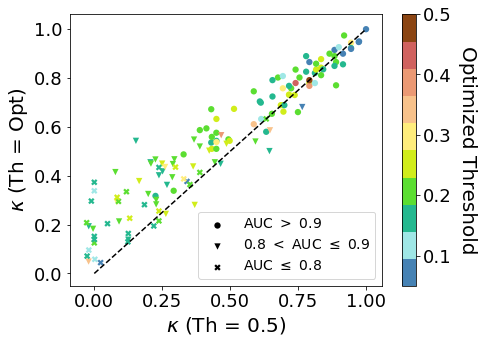

In [43]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'standard', yax = 'GHOST', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_ThOpt_vs_Th05.png", 
                    cmap = cmap3, norm = None, transparency = 1)

In [50]:
if method == 'RF' and opt_oob:
    scatterplot_results_th_diff(df_kappa, df_kappa, df_thresholds, df_thresholds, df_auc, 
                    xax = 'GHOST', yax = 'OobOpt', x_lab = "$\kappa$ (Th = Opt)", y_lab = "$\kappa$ (Th = OobOpt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_ThOpt_vs_ThOob.png", 
                    cmap = cmap4, norm = None, transparency = 1)

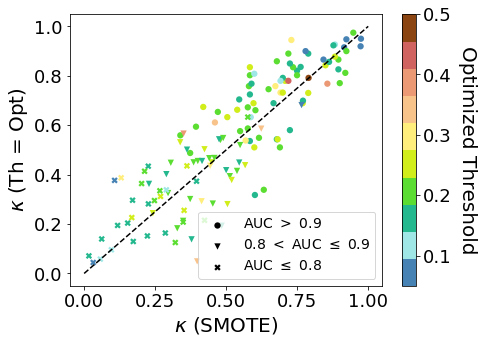

In [51]:
if try_resampling:
    scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'SMOTE', yax = 'GHOST', x_lab = "$\kappa$ (SMOTE)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_SMOTE.png", 
                    cmap = cmap3, norm = None, transparency = 1)

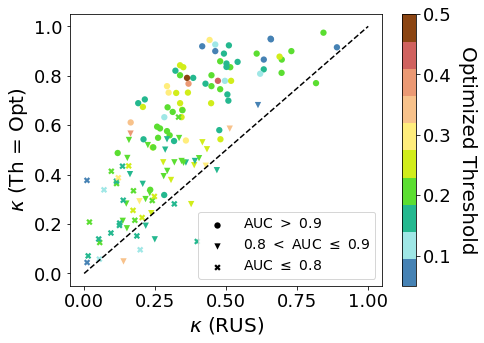

In [52]:
if try_resampling:
    scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'RUS', yax = 'GHOST', x_lab = "$\kappa$ (RUS)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_RUS.png", 
                    cmap = cmap3, norm = None, transparency = 1)

### Compare to CP

In [47]:
import glob

if try_cp:
    files_preds = glob.glob(f"results/{basename}_predictions_*.csv")
    ACP_significance_level = 0.2

**Comparison between generalized threshold optimization and CP.**

For a fair comparison, in the plot below, we compare only the predictions where CP produced statistically significant results (at a ACP significance level of 0.2):

In [48]:
# calculate Cohen's kappa only on single predictions
if try_cp:
    assay_ids = []
    kappa_cp = [] 
    kappa_cp_single = [] 
    kappa_th05_single = []
    kappa_thopt_single = []
    for f1 in files_preds:
        assay_ids.append(f1.split('_')[3].replace('.csv',''))
        df_preds1 = pd.read_csv(f1)
        df_preds1['uncertain_CP'] = 0
        df_preds1['uncertain_CP'][df_preds1['p1'] >= df_preds1['p0']] = 1
        tmp = df_preds1.loc[(df_preds1[f'y_pred_{ACP_significance_level}']=="0") | (df_preds1[f'y_pred_{ACP_significance_level}']=="1")]
        print(tmp)
        kappa_cp_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.uncertain_CP))
        kappa_th05_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.Th05))
        kappa_thopt_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.ThOpt))
    df_kappa = df_kappa.reset_index().rename(columns = {'index': 'assay_id'})
    df_cp = pd.DataFrame({'assay_id': assay_ids, 'CP_single': kappa_cp_single, 'Th05_single':kappa_th05_single, 'GHOST_single': kappa_thopt_single})
    df_kappa = pd.merge(df_kappa, df_cp, how = 'left', on = 'assay_id')


In [49]:
if try_cp:
    scatterplot_results(df_kappa, df_kappa, df_thresholds.rename(columns = {'ThOpt': 'ThOpt_single'}), df_auc, 
                    xax = 'CP_single', yax = 'GHOST_single', x_lab = "$\kappa$ (CP, single pred.)", y_lab = "$\kappa$ (Th = Opt, single pred.)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_CP.png", 
                    cmap = cmap3, norm = None, transparency = 1)